# GridWorld 2:

*GridWorld* es un mundo en forma de cuadrícula muy utilizado como entorno de pruebas para técnicas de Aprendizaje por Refuerzo. Dentro de esta cuadrícula hay varios tipos de celdas: iniciales, libres, obstáculos, terminales... ¡y ahora también agujeros de gusano! Los agentes tienen que llegar desde una celda inicial hasta otra terminal evitando los obtáculos y recorriendo una distancia mínima.

Paquetes necesarios para *GridWorld 2*:

In [ ]:
import numpy as np
import math
import random
from IPython.display import clear_output
import time
import pandas as pd

Funciones auxiliares para visualizar información:

In [ ]:
def printMap(world):
  # Visualiza el mapa de GridWorld
  m = ""
  for i in range(world.size[0]):
    for j in range(world.size[1]):
      if world.map[(i, j)] == 0:
        m += " O "
      elif world.map[(i, j)] == -1:
        m += " X "
      elif world.map[(i, j)] == 1:
        m += " F "
      elif world.map[(i, j)] == 2:
        m += " T "
    if i == world.size[0] - 1:
      m += "\n"
    else:
      m += "\n"
  print(m)

def printPolicy(world, policy):
  # Visualiza la política con flechas
  p = ""
  for i in range(world.size[0]):
    for j in range(world.size[1]):
      if world.map[(i,j)]==-1:
        p+= " X "
      elif world.map[(i,j)]==1:
        p+= " F "
      elif world.map[(i, j)] == 2:
        p += " T "
      else:
        if policy[i][j] == 0:
          p += " ^ "
        elif policy[i][j] == 1:
          p += " V "
        elif policy[i][j] == 2:
          p += " < "
        elif policy[i][j] == 3:
          p += " > "
        else:
          p += " x "
    if i == world.size[0] - 1:
      p += "\n"
    else:
      p += "\n"
  print(p)

# Clase *World*:

Esta clase almacena la información del mundo:

*   *Map*: Matriz con la codificación del mundo con celdas libres (0), obstáculos (-1) y terminales (1)
*   *Size*: Vector con el tamaño de la matriz de codificación del mundo (ancho, alto)

Para crear un mundo hay que aportar los siguientes datos:

*   Tamaño del mapa (ancho, alto)
*   Lista de celdas terminales
*   Lista de celdas con obstáculos
*   Agujero de gusano

Notas:

* Cuando el agente cae en un obstáculo se queda atrapado para siempre en él
* Cuando el agente entra por un extremo del agujero de gusano sale por el otro extremo

Por ejemplo:

w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])

Crea un mundo de 10 filas y 10 columnas con un estado terminal (9, 9), dos obstáculos en (2, 4) y (4, 2) y un teletransporte entre (0, 2) y (9, 7).

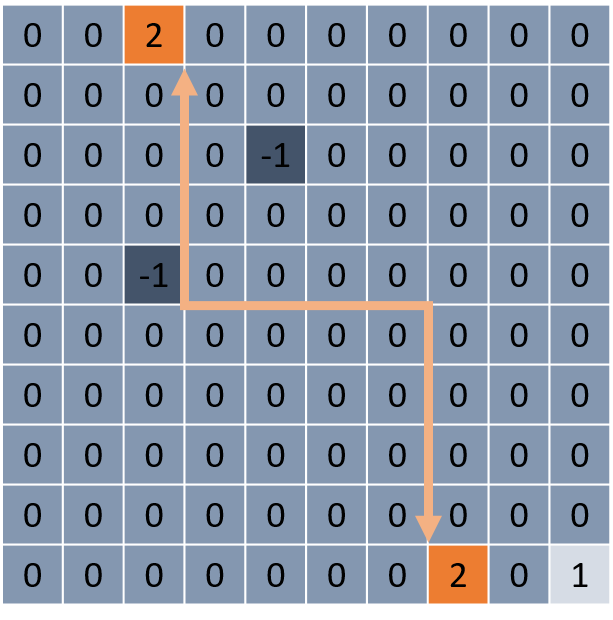

In [ ]:
class World:

  def __init__(self, size, terminal, obstacle, hole):
    # Crea un mundo
    self.size = size
    self.map = {}
    for i in range(size[0]):
      for j in range(size[1]):
        # Estados libres
        self.map[(i, j)] = 0
        # Estados terminales
        for t in terminal:
          if i==t[0] and j==t[1]:
            self.map[(i, j)] = 1
        # Estados con obstáculos
        for o in obstacle:
          if i==o[0] and j==o[1]:
            self.map[(i, j)] = -1
        for h in hole:
          if i==h[0] and j==h[1]:
            self.map[(i, j)] = 2

  def objetivo(self,state):
    return self.map[(state[0], state[1])] == 1

Prueba de la clase *World*:

In [ ]:
if __name__ == "__main__":
  w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])
  printMap(w)

 O  O  T  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  T  O  F 



# Clase *Agent*:

Esta clase controla el agente que aprende por refuerzo en *GridWorld*.

Para crear un agente se necesitan los siguientes datos:

*   *World*: Mundo en el que se desenvuelve el agente.
*   *Initial State*: Estado inicial del agente.

Para controlar el agente se usan los siguientes métodos:

*   *nextState = move(state, action)*: Mueve el agente del estado *state* a un nuevo estado *nextState* aplicando una acción *action*.
*   *reward = reward(nextState)*: Devuelve el refuerzo *reward* que recibe el agente al transicionar al estado *nextState*.
*   *nextState, reward = checkAction(state, action)*: Comprueba a qué estado *nextState* y con qué refuerzo *reward* cambia el agente al aplicar la acción *action* en el estado *state*. Este método no cambia el estado interno del agente, por lo que puede usarse para hacer barridos del espacio de estados.
*   *nextState, reward = executeAction(action)*: Ejecuta la acción *action* en el estado actual y devuelve el nuevo estado *nextState* y el refuerzo *reward*. Este método cambia el estado interno del agente, por lo que sólo debe usarse cuando se realice un recorrido por el mundo.

Nota: Podéis hacer cambios en el agente (distribución de refuerzos, comportamiento en obstáculos...) buscando mejorar el rendimiento de los algoritmos.

### Cambios en el agente

Se ha realizado un combio en la función reward, con el objetivo de encontrar el camino más corto hacia el estado terminal antes de converger, así dandole más prioridad. Para ello, por cada movimiento a una casilla vacia obtendra un pequeño refuerzo negativo.

Tabién se ha modificado la función checkAction y executeAction con el objetivo de cmbiar la interacción que se tiene con los obstáculos. En vez de quedarse el agente pillado en el obstaculo, tendra un efecto de rebote y volvera a la casilla anterior a pisar el obstáculo. Para ello en vez de tener en cuenta el estado actual para hacer un movimiento, se tendra el siguiente estado.

También se ha añadido una función llamada estado_final para detectar cuando llegemos a la meta del laberinto, que llama a una nueva función en la clase World que realiza esto mismo.

In [ ]:
class Agent:

  def __init__(self, world, initialState):
    # Crea un agente
    self.world = world
    self.state = np.array(initialState)

  def move(self, state, action):
    # Gestiona las transiciones de estados
    nextState = state + np.array(action)
    if nextState[0] < 0:
      nextState[0] = 0
    elif nextState[0] >= self.world.size[0]:
      nextState[0] = self.world.size[0] - 1
    if nextState[1] < 0:
      nextState[1] = 0
    elif nextState[1] >= self.world.size[1]:
      nextState[1] = self.world.size[1] - 1
    if self.world.map[(nextState[0], nextState[1])] == 2:
      aux = nextState
      for i in range(self.world.size[0]):
        for j in range(self.world.size[1]):
          if self.world.map[(i, j)] == 2 and (nextState[0] != i and nextState[1] != j):
            aux = np.array([i, j])
            nextState = aux
            break
    return nextState

  def reward(self, nextState):
    # Gestiona los refuerzos
    if self.world.map[(nextState[0], nextState[1])] == -1:
      # Refuerzo cuando el agente intenta moverse a un obstáculo
      reward = -2 # ** Prueba varios valores **
    elif self.world.map[(nextState[0], nextState[1])] == 1:
      # Refuerzo cuando el agente se mueve a una celda terminal
      reward = 1 # ** Prueba varios valores **
    else:
      # Refuerzo cuando el agente se mueve a una celda libre
      reward = -0.1 # ** Prueba varios valores **
    return reward

  def checkAction(self, state, action):
    # Planifica una acción
    nextState = self.move(state, action)
    if self.world.map[(nextState[0], nextState[1])] == -1:
      nextState = state
    reward = self.reward(nextState)
    return nextState, reward

  def executeAction(self, action):
    # Planifica y ejecuta una acción
    nextState = self.move(self.state, action)
    if self.world.map[(nextState[0], nextState[1])] == -1:
      nextState = self.state
    else:
      self.state = nextState
    reward = self.reward(nextState)
    return self.state, reward

  def estado_final(self,state):
    return self.world.objetivo(state)

Prueba de la clase *Agent*:

In [ ]:
if __name__ == "__main__":
  # Crear el mundo
  w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])
  printMap(w)
  # Crear el agente
  a = Agent(w, (0, 0))
  # Mover el agente en la diagonal principal
  for i in range(1, 5):
    # Mostrar cada nuevo estado y su recompensa
    print(a.executeAction((0, 1)))

 O  O  T  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  T  O  F 

(array([0, 1]), -0.1)
(array([9, 7]), -0.1)
(array([9, 8]), -0.1)
(array([9, 9]), 1)


# Trabajo:

En este trabajo vais a implementar los dos algoritmos más comunes de aprendizaje por refuerzo basados en el valor: SARSA y QLearning. Además, vais a probar ambos algoritmos en una serie de escenarios para evaluar su funcionamiento y comparar sus resultados.

## Mundos:

Para probar los algoritmos se ofrecen los siguientes mundos en varios tamaños:

*   Mundo 1: Laberinto fácil que se puede recorrer en zigzag
*   Mundo 2: Mundo con obstáculos aleatorios en el que el teletransporte acorta la distancia desde el inicio hasta el final
*   Mundo 3: Mundo con obstáculos aleatorios en el que el teletransporte no reduce la distancia desde el inicio hasta el final
*   Mundo 4: Laberinto difícil con caminos correctos y equivocados

Nota: Sentíos libres de utilizar todos o algunos de estos escenarios o directamente crear vuestros propios escenarios.

In [ ]:
if __name__ == "__main__":

  np.random.seed(1000)
  # Mundo 1 pequeño: Laberinto fácil
  obstacles = []
  for j in range(0, 4):
    obstacles.append((j, 1))
  for j in range(1, 5):
    obstacles.append((j, 3))
  w1p = World((5, 5), [(4, 4)], obstacles, [])
  print("World 1: ")
  printMap(w1p)

  # Mundo 1 mediano: Laberinto fácil
  obstacles = []
  for i in [1, 5]:
    for j in range(0, 8):
      obstacles.append((j, i))
  for i in [3, 7]:
    for j in range(1, 9):
      obstacles.append((j, i))
  w1m = World((9, 9), [(8, 8)], obstacles, [])
  print("World 1: ")
  printMap(w1m)

  # Mundo 1 grande: Laberinto fácil
  obstacles = []
  for i in [1, 5, 9, 13, 17]:
    for j in range(0, 20):
      obstacles.append((j, i))
  for i in [3, 7, 11, 15, 19]:
    for j in range(1, 21):
      obstacles.append((j, i))
  w1g = World((21, 21), [(20, 20)], obstacles, [])
  print("World 1: ")
  printMap(w1g)

  # Mundo 2 pequeño: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(3):
    obstacles.append((np.random.randint(1, 4), np.random.randint(1, 4)))
  w2p = World((5, 5), [(4, 4)], obstacles, [(2, 0), (4, 2)])
  print("World 2: ")
  printMap(w2p)

  # Mundo 2 mediano: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(10):
    obstacles.append((np.random.randint(1, 9), np.random.randint(1, 9)))
  w2m = World((10, 10), [(9, 9)], obstacles, [(3, 1), (8, 6)])
  print("World 2: ")
  printMap(w2m)

  # Mundo 2 grande: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(50):
    obstacles.append((np.random.randint(1, 19), np.random.randint(1, 19)))
  w2g = World((21, 21), [(20, 20)], obstacles, [(6, 2), (18, 14)])
  print("World 2: ")
  printMap(w2g)

  # Mundo 3 pequeño: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(3):
    obstacles.append((np.random.randint(1, 4), np.random.randint(1, 4)))
  w3p = World((5, 5), [(4, 4)], obstacles, [(4, 0), (0, 4)])
  print("World 3: ")
  printMap(w3p)

  # Mundo 3 mediano: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(10):
    obstacles.append((np.random.randint(1, 9), np.random.randint(1, 9)))
  w3m = World((10, 10), [(9, 9)], obstacles, [(8, 1), (1, 8)])
  print("World 3: ")
  printMap(w3m)

  # Mundo 3 grande: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(50):
    obstacles.append((np.random.randint(1, 19), np.random.randint(1, 19)))
  w3g = World((21, 21), [(20, 20)], obstacles, [(18, 2), (2, 18)])
  print("World 3: ")
  printMap(w3g)

  # Mundo 4: Laberinto difícil
  obstacles = [(0,1),(0,3),(0,9),(0,15),(0,16),(0,17),(0,19),
               (1,1),(1,3),(1,4),(1,5),(1,6),(1,7),(1,9),(1,10),(1,11),(1,12),(1,13),(1,17),(1,19),
               (2,1),(2,9),(2,13),(2,15),(2,16),(2,17),(2,19),
               (3,1),(3,3),(3,5),(3,7),(3,9),(3,11),(3,16),(3,19),
               (4,3),(4,5),(4,7),(4,8),(4,9),(4,10),(4,11),(4,12),(4,13),(4,14),(4,16),(4,18),(4,19),
               (5,0),(5,1),(5,2),(5,3),(5,5),(5,9),(5,16),
               (6,5),(6,6),(6,7),(6,9),(6,10),(6,11),(6,12),(6,13),(6,14),(6,16),(6,17),(6,19),
               (7,0),(7,1),(7,2),(7,3),(7,5),(7,7),(7,9),(7,19),
               (8,3),(8,7),(8,8),(8,9),(8,12),(8,13),(8,14),(8,15),(8,16),(8,17),(8,18),(8,19),
               (9,1),(9,3),(9,5),(9,7),(9,11),(9,12),(9,19),(9,20),
               (10,1),(10,3),(10,5),(10,6),(10,7),(10,9),(10,11),(10,14),(10,15),(10,16),(10,17),
               (11,1),(11,3),(11,5),(11,9),(11,11),(11,13),(11,14),(11,17),(11,18),(11,19),
               (12,1),(12,5),(12,6),(12,8),(12,9),(12,11),(12,13),(12,19),
               (13,1),(13,2),(13,3),(13,4),(13,5),(13,8),(13,15),(13,16),(13,17),(13,19),
               (14,4),(14,7),(14,8),(14,10),(14,12),(14,13),(14,15),(14,19),
               (15,0),(15,1),(15,2),(15,6),(15,7),(15,10),(15,13),(15,14),(15,15),(15,17),(15,18),(15,19),(15,20),
               (16,2),(16,3),(16,5),(16,6),(16,7),(16,8),(16,9),(16,10),(16,11),(16,15),(16,17),
               (17,0),(17,3),(17,5),(17,9),(17,13),(17,14),(17,15),(17,17),(17,19),
               (18,0),(18,1),(18,5),(18,6),(18,7),(18,9),(18,10),(18,11),(18,15),(18,19),
               (19,1),(19,2),(19,4),(19,5),(19,11),(19,13),(19,14),(19,15),(19,16),(19,17),(19,18),(19,19),
               (20,7),(20,8),(20,9),(20,11),(20,19)]
  print("World 4: ")
  w4 = World((21, 21), [(20, 20)], obstacles, [])
  printMap(w4)

World 1: 
 O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F 

World 1: 
 O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F 

World 1: 
 O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X 

### Funciones comunes para los algoritmos de Sarsa y Qlearn

Antes recordar que se han realizado cambios en la clase Agent y uno pequeño en la clase World explicados en el apartado "Cambio en el agente".

En esta sección se implementa todas las funciones que se utilizan para la ejecución de los dos algoritmos, las cuales son las siguientes:

- explorar_explotacion(Q, S, epsilon, actions): Implementa una estrategia que equilibra la exploración de nuevas acciones con la explotación de las acciones más prometedoras basadas en los valores Q aprendidos hasta el momento. Donde epsilon es un factor utilizado para equilibrar la exploración y la explotación.

  - La función genera un número aleatorio entre 0 y 1. Si este número es menor que epsilon, el agente elige explorar, lo que significa que seleccionará una acción al azar de la lista de acciones disponibles.

  - Si el número aleatorio es igual o mayor que epsilon, el agente elige explotar, lo que significa que seleccionará la acción que tenga el valor Q más alto para el estado actual S.
- politica(world, Q): Este método toma la información aprendida sobre los valores de acción (Q) y genera una política que especifica la mejor acción a tomar en cada estado.
- evaluar_politica(policy, world, agent, actions): Esta función proporciona una evaluación de la efectividad de una política dada en un entorno específico al permitir que un agente siga esa política y registre si el agente logra o no alcanzar el objetivo dentro de un número determinado de pasos.
- ejecucion_episodio(Q, episodio, world, agent, actions, alpha, epsilon, gamma, algorithm, verbose, max_steps): Función que implementa un episodio completo de aprendizaje por refuerzo utilizando un algoritmo, actualizando la matriz de valores Q y evaluando la política resultante en el entorno dado.

  - alpha: Tasa de aprendizaje utilizada en la actualización de los valores Q. La tasa de aprendizaje controla la rapidez con la que el agente actualiza sus estimaciones de los valores Q a medida que interactúa con el mundo y recibe recompensas. Un valor más alto hara que confie más en las nuevas acciones y un valor bajo será más conservador, por lo que dara menos peso a las nuevas acciones.

  - gamma: Factor de descuento que determina la importancia relativa de las recompensas futuras. Cuando el descuento es cercano a 1, se consideran las recompensas futuras con un peso significativo en la estimación del valor Q, lo que implica una preferencia por obtener recompensas a largo plazo. Por otro lado, cuando el descuento es cercano a 0, las recompensas futuras tienen menos influencia, lo que lleva a un enfoque más orientado hacia la obtención de recompensas inmediatas.

  - algorithm: Algoritmo de actualización de los valores de Q (SARSA o QLearn)

  - verbose: Indicador que controla si se imprime información sobre el proceso de aprendizaje durante la ejecución, es decir muestra el progreso de la política en cada episodio.

  - max_steps: Número máximo de pasos permitidos en un episodio antes de terminarlo.

- ejecucion_total_episodios(world, agent, actions, alpha, epsilon, gamma, num_episodios, algorithm, verbose1, verbose2, max_steps): Función que ejecuta múltiples episodios de aprendizaje por refuerzo utilizando un algoritmo y proporciona información sobre el proceso de aprendizaje, incluyendo la matriz de valores Q resultante y el mejor camino encontrado. Si la política no converge después de todos los episodios, se imprime un mensaje indicando que no convergió y devolviendo un -1 como tamaño del mejor camino.

  - num_episodios: Número total de episodios que se van a ejecutar.
  - verbose1: Indicador que controla si se imprime información sobre el proceso de aprendizaje durante la ejecución, es decir muestra el progreso de la política en cada episodio.
  - verbose2: Indicador que controla si muestra que el proceso ha convergido, en cuantos episodios y el tamaño del mejor camino y en caso de no converger imprimir que lo ha hecho y un -1 en el valor del mejor camino.

- policy(world, alpha, epsilon, gamma=1.0, n_episodes=500, algorithm = None,
verbose1=False, verbose2=True, max_steps=1000): Función que integra varios pasos del proceso de aprendizaje por refuerzo, desde el aprendizaje de la función valor Q hasta la derivación de la política óptima y proporciona información relevante sobre el proceso de aprendizaje como es la poítica óptima, el tamaño del mejor camino o el número de episodios en el que ha convergido o si no lo ha hecho.


In [ ]:
estado_inicial = (0, 0)
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

In [ ]:
def explorar_explotacion(Q, S, epsilon, actions):
    if np.random.uniform() < epsilon:
        # Escoger una accion al azar
        return random.randint(0,len(actions)-1)
    else:
        # Escoger valor mayor
        valores_accion = Q[S[0], S[1], :]
        max_indices = np.where(valores_accion == np.max(valores_accion))[0]
        indice_max=random.choice(max_indices)
        return indice_max

def politica(world, Q):
    politica = np.zeros(world.size, dtype = np.int8)
    for i in range(world.size[0]):
        for j in range(world.size[1]):
            politica[i, j] = np.argmax(Q[i, j, :])
    return politica


def evaluar_politica(policy, world, agent, actions):
    state = agent.state

    # Si no llega al objetivo en un número de pasos, ha entrado en un ciclo. Numero de pasos igual a tamaño del laberinto
    for step in range(world.size[0]*world.size[1]):
        if world.objetivo(state):
            return True, step

        indice_accion = policy[state[0], state[1]]
        accion = actions[indice_accion]
        state,_ = agent.checkAction(state, accion)

    #-1 si no ha llegado
    return False, -1


def ejecucion_episodio(Q, episodio, world, agent, actions,
                         alpha, epsilon, gamma, algorithm,
                         verbose, max_steps):
    S = agent.state

    # Escoger acción basado en Q(S',-)
    indice_accion_ant = explorar_explotacion(Q, S, epsilon, actions)
    A_actual = actions[indice_accion_ant]

    # Bucle hasta llegar al estado terminal
    for step in range(max_steps):
        # Estado final
        if agent.estado_final(S):
            break

        # Observar el proximo estado y elegir la proxima acción de forma adecuada
        nextState, R = agent.checkAction(S, A_actual)
        indice_accion_act = explorar_explotacion(Q, nextState, epsilon, actions)
        action = actions[indice_accion_act]

        # Actualizar Q
        Q[S[0], S[1], indice_accion_ant] = algorithm(Q, R, S, alpha, gamma, nextState, indice_accion_act, indice_accion_ant)
        # Paso de avance
        S = nextState
        A_actual = action
        indice_accion_ant = indice_accion_act

    policy = politica(world, Q)

    if verbose:
        clear_output()
        print(f"Episodio {episodio + 1}")
        printPolicy(world, policy)
        time.sleep(1)

    converge, num_pasos = evaluar_politica(policy, world, agent, actions)

    return converge, num_pasos


def ejecucion_total_episodios(world, agent, actions, alpha, epsilon,
                   gamma, num_episodios, algorithm,
                   verbose1,verbose2, max_steps):

    # Initializacion
    Q = np.zeros((*world.size, len(actions)))
    converge = False
    caminos = []
    np.random.seed(1000)

    # Bucle por los episodes
    for episodio in range(num_episodios):
        converge, num_pasos = ejecucion_episodio(Q, episodio, world, agent, actions,
                                 alpha, epsilon, gamma, algorithm, verbose1, max_steps)
        caminos.append(num_pasos)

        if converge:
            if (verbose2):
              print(f"Converge en {episodio + 1} episodios. "
                    f"Tamaño: {num_pasos}")
            mejor_Q = Q.copy()
            mejor_camino = num_pasos
            break

    episodios = episodio + 1
    if not converge:
        if(verbose2):
          print(f"No converge en {episodios + 1} episodios")
        mejor_camino = -1

    return Q, episodios, converge, mejor_camino, caminos


def policy(world, alpha, epsilon, gamma=1.0,
           n_episodes=500, algorithm = None,
           verbose1=False,verbose2=True, max_steps=1000):

    agent = Agent(world, estado_inicial)
    np.random.seed(1000)
    random.seed(1000)

    # Aprender la funcion valor Q
    Q, episodios, converge, mejor_camino, caminos = \
        ejecucion_total_episodios(world, agent, actions, alpha,
                       epsilon, gamma,n_episodes, algorithm, verbose1,verbose2, max_steps)

    # Computar la politica basada en Q
    policy = politica(world, Q)

    return policy, Q, episodios, converge, caminos, mejor_camino

## SARSA:

*SARSA* (State-Action-Reward-State-Action) es un método basado en el valor que permite resolver problemas de aprendizaje por refuerzo. Al igual que el resto de métodos basados en el valor, *SARSA* calcula de forma iterativa la función de valor $Q(S,A)$ y, a partir de ella, determina la política óptima $\pi$.

*SARSA* recibe su nombre de las cinco variables implicadas en su función de actualización: el estado actual ($S_t$), la acción actual ($A_t$), el refuerzo actual ($R_t$), el siguiente estado ($S_{t+1}$) y la siguiente acción ($A_{t+1}$). Esta función de actualización tiene la siguiente forma:

\begin{equation}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t,A_t)]
\end{equation}

Nota: $\alpha$ es la longitud del episodio y $\gamma$ el factor de descuento.

El algoritmo *SARSA* sigue el siguiente esquema:

1.   Inicializar $Q(S,A)$ para todos los estados y acciones
2.   **Bucle** (repetir $3-9$ hasta la convergencia):
3.   Inicializar $S_t$
4.   Elegir $A_t$ en $S_t$ siguiendo la política derivada de $Q(S,A)$
5.   **Bucle** (repetir $6-9$ hasta que $S_t$ sea terminal):
6.   Tomar la acción $A_t$ en $S_t$ y observar $R_t$ y $S_{t+1}$
7.   Elegir $A_{t+1}$ en $S_{t+1}$ siguiendo la política derivada de $Q(S,A)$
8.   Actualizar el valor $Q(S_t, A_t)$ con la función de actualización
9.   Tomar $S_{t+1}$ y $A_{t+1}$ como los nuevos $S_t$ y $A_t$

El algoritmo *SARSA* utiliza un parámetro $\epsilon \in (0, 1)$ para buscar un equilibrio entre exploración y explotación. A la hora de elegir $A_t$ en $S_t$, si un número aleatorio es menor que $\epsilon$, el algoritmo tomará una acción aleatoria; mientras que si ese número aleatorio es mayor que $\epsilon$, el algoritmo tomará la mejor acción conocida.

## Ejercicio 1:

Implementad el algoritmo SARSA para el agente y entorno definidos anteriormente.


Dado el esqueleto de arriba, solo tenemos que implementar la función de actualización de Q según SARSA, que sería el parámetro algorithm de la función de policy encargada de la ejecución de todo el proceso de entrenamiento. Los parametros ya han sido explicados en el apartado de las funciones comunes del apartado anterior.

In [ ]:
# Resolución: Código de SARSA

def SARSA(Q, R, S, alpha, gamma, accion_sig, indice_accion_sig, indice_accion_act):
    return (Q[S[0], S[1], indice_accion_act]
            + alpha*(R + gamma*Q[accion_sig[0], accion_sig[1], indice_accion_sig]
            - Q[S[0], S[1], indice_accion_act]))

A continuación se realizan distintas pruebas en todos los mapas en los que se realizan cambios en el valor alpha (factor de aprendizaje), epsilon(factor que afecta la probabilidad de exploración) y gamma(factor de descuento).
Para entender mejor los resultados se explica lo siguiente:

- A la hora de visualizar las políticas, pintamos los obstáculos con 'X', la meta con 'F', y los túneles con "T" como la función de imprimir el mundo.
- Esta la opción de activar el parametro verbose para observar como cambia la política en cada episodio. Pero se dejara desactivado por temas de eficiencia y coste computacional en todos los casos.
- En los mapas grandes se aumenta el número máximo de pasos por episodio, para dejar que el agente haga un recorrido más largo en cada episodio y le de tiempo a converger.

## Pruebas simples
Simplemente para ver simplemente el funcionamiento con los siguientes valores arbitrarios alpha=0.2, epsilon (modo explotación) y gamma=1

## Mapa 1

In [ ]:
policy_w1p, Q, episodios, converge, caminos, mejor_camino = policy(
    w1p, alpha=0.2, epsilon=0.0, n_episodes=100, algorithm = SARSA
)
printPolicy(w1p, policy_w1p)

Converge en 42 episodios. Tamaño: 16
 V  X  >  >  V 
 V  X  ^  X  V 
 V  X  ^  X  V 
 V  X  ^  X  V 
 >  >  ^  X  F 



In [ ]:
policy_w1m, Q, episodios, converge, caminos, mejor_camino = policy(
    w1m, alpha=0.2, epsilon=0.0, n_episodes=500, algorithm = SARSA
)
printPolicy(w1m, policy_w1m)

Converge en 171 episodios. Tamaño: 48
 V  X  >  >  V  X  >  >  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 >  >  ^  X  >  >  ^  X  F 



In [ ]:
policy_w1g, Q, episodios, converge, caminos, mejor_camino = policy(
    w1g, alpha=0.2, epsilon=0.0, n_episodes=5000, algorithm = SARSA
)
printPolicy(w1g, policy_w1g)

Converge en 1307 episodios. Tamaño: 240
 V  X  >  >  V  X  >  >  V  X  >  >  V  X  >  >  V  X  >  >  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 


## Mapa 2

In [ ]:
policy_w2p, Q, episodios, converge, caminos, mejor_camino = policy(
    w2p, alpha=0.2, epsilon=0.0, n_episodes=100, algorithm = SARSA
)
printPolicy(w2p, policy_w2p)

Converge en 7 episodios. Tamaño: 4
 V  <  >  V  ^ 
 V  V  X  X  ^ 
 T  X  ^  ^  V 
 ^  ^  V  ^  V 
 ^  ^  T  >  F 

El mejor camino es de tamaño 4


In [ ]:
policy_w2m, Q, episodios, converge, caminos, mejor_camino = policy(
    w2m, alpha=0.2, epsilon=0.0, n_episodes=100, algorithm = SARSA
)
printPolicy(w2m, policy_w2m)

Converge en 12 episodios. Tamaño: 8
 V  <  ^  V  V  ^  ^  ^  V  ^ 
 >  V  X  X  V  V  V  ^  ^  > 
 V  V  <  ^  >  X  X  ^  >  < 
 <  T  ^  X  <  V  <  ^  >  V 
 V  V  <  V  V  V  >  >  V  ^ 
 ^  ^  <  X  X  X  V  V  <  < 
 V  >  >  >  V  V  <  ^  X  < 
 V  V  X  ^  <  >  >  >  V  V 
 V  >  ^  V  V  V  T  V  ^  V 
 ^  ^  <  <  <  V  >  >  >  F 

El mejor camino es de tamaño 8


In [ ]:
policy_w2g, Q, episodios, converge, caminos, mejor_camino = policy(
    w2g, alpha=0.2, epsilon=0.0, n_episodes=1000, algorithm = SARSA
)
printPolicy(w2g, policy_w2g)

Converge en 100 episodios. Tamaño: 16
 V  V  V  <  <  <  ^  ^  >  <  <  <  V  V  <  ^  >  V  >  V  ^ 
 V  ^  V  V  X  >  >  >  V  ^  >  ^  ^  X  <  ^  V  >  >  ^  V 
 V  X  <  >  V  <  V  ^  ^  >  >  V  V  >  ^  V  ^  ^  ^  V  > 
 V  X  V  <  ^  V  V  ^  V  >  V  ^  X  ^  X  V  V  ^  ^  <  V 
 V  V  V  ^  V  <  >  X  ^  V  <  <  X  >  X  V  X  V  <  <  V 
 >  V  V  X  V  X  >  V  X  ^  >  <  V  <  V  X  ^  X  >  >  V 
 >  >  T  <  <  ^  >  V  ^  X  V  V  >  V  V  <  ^  <  <  ^  ^ 
 ^  <  ^  V  <  V  ^  ^  ^  V  <  >  <  V  V  ^  >  <  >  ^  V 
 ^  X  V  V  <  <  >  ^  <  ^  V  ^  <  <  V  <  ^  ^  V  ^  ^ 
 ^  X  X  V  <  >  >  V  V  ^  V  V  ^  <  ^  ^  <  X  <  <  ^ 
 >  <  <  <  ^  <  V  X  V  ^  X  V  <  V  X  V  V  <  <  ^  V 
 <  >  V  V  <  >  <  V  >  V  <  X  ^  <  V  >  X  ^  V  ^  V 
 <  X  <  ^  V  V  V  V  V  V  ^  V  V  X  <  X  ^  <  <  <  V 
 ^  V  ^  >  >  X  <  ^  ^  V  V  <  X  X  >  V  <  V  >  V  V 
 <  V  X  ^  V  ^  V  V  >  V  >  X  V  <  X  V  >  >  <  >  V 
 V

## Mapa 3

In [ ]:
policy_w3p, Q, episodios, converge, caminos, mejor_camino = policy(
    w3p, alpha=0.2, epsilon=0.0, n_episodes=100, algorithm = SARSA
)
printPolicy(w3p, policy_w3p)

Converge en 19 episodios. Tamaño: 8
 V  <  V  V  T 
 V  >  ^  <  V 
 >  V  X  X  V 
 <  V  X  ^  V 
 T  >  >  >  F 

El mejor camino es de tamaño 8


In [ ]:
policy_w3m, Q, episodios, converge, caminos, mejor_camino= policy(
    w3m, alpha=0.2, epsilon=0.0, n_episodes=1000, algorithm = SARSA
)
printPolicy(w3m, policy_w3m)

Converge en 110 episodios. Tamaño: 18
 >  >  V  ^  V  V  V  V  ^  V 
 V  X  >  >  >  >  V  >  T  ^ 
 ^  V  X  >  X  V  V  >  V  V 
 ^  X  X  V  <  V  V  >  >  V 
 ^  >  V  V  >  >  V  <  >  V 
 >  <  >  X  >  >  V  ^  V  V 
 >  V  V  V  V  X  V  X  >  V 
 ^  X  >  >  >  >  V  V  >  V 
 >  T  >  >  V  >  V  V  <  V 
 ^  >  >  >  >  >  >  >  >  F 

El mejor camino es de tamaño 18


In [ ]:
policy_w3g, Q, episodios, converge, caminos, mejor_camino = policy(
    w3g, alpha=0.2, epsilon=0.1, n_episodes=5000, algorithm = SARSA
)
printPolicy(w3g, policy_w3g)

Converge en 587 episodios. Tamaño: 40
 V  V  >  ^  V  ^  >  V  >  >  >  V  <  >  >  <  ^  V  >  <  V 
 >  >  >  >  >  >  >  >  V  V  >  V  >  >  V  ^  X  X  >  V  V 
 V  >  <  V  ^  <  ^  V  V  ^  V  >  X  >  V  <  <  >  T  ^  V 
 ^  V  ^  V  X  >  >  <  >  >  >  V  ^  X  ^  >  ^  <  X  V  ^ 
 <  >  V  ^  ^  V  V  ^  X  V  X  V  X  ^  ^  ^  X  V  V  V  > 
 >  >  ^  >  >  V  >  ^  X  V  ^  V  V  X  ^  V  V  >  >  V  V 
 ^  V  <  <  X  >  V  >  >  V  >  V  >  >  V  ^  V  X  X  V  V 
 ^  V  V  >  V  ^  V  X  >  <  X  V  X  X  V  X  >  >  V  V  V 
 ^  <  X  V  >  X  >  >  ^  V  X  >  V  >  >  V  V  >  >  >  V 
 <  ^  X  >  >  >  >  >  >  >  >  <  V  X  >  V  V  V  >  >  V 
 V  V  V  ^  V  X  >  V  <  >  V  X  >  V  X  V  V  >  >  >  V 
 >  ^  >  V  >  ^  V  <  <  X  V  X  V  >  >  >  V  X  X  V  V 
 <  X  V  >  ^  V  >  V  >  V  >  >  V  >  >  >  >  V  >  V  V 
 >  <  >  V  V  <  X  V  X  V  V  X  V  V  V  ^  X  >  >  V  V 
 <  X  V  V  V  X  V  >  >  >  >  V  V  V  V  X  <  >  >  >  V 
 V

## Mapa 4

In [ ]:
policy_w4, Q, episodios, converge, caminos, mejor_camino = policy(
    w4, alpha=0.2, epsilon=0.0, n_episodes=10000, algorithm = SARSA
)
printPolicy(w4, policy_w4)

Converge en 409 episodios. Tamaño: 82
 V  X  >  X  ^  <  V  <  <  X  V  V  V  <  <  X  X  X  >  X  ^ 
 V  X  >  X  X  X  X  X  <  X  X  X  X  X  ^  >  V  X  ^  X  < 
 V  X  >  >  V  >  ^  V  V  X  V  <  <  X  ^  X  X  X  >  X  ^ 
 V  X  ^  X  V  X  V  X  V  X  V  X  V  V  <  <  X  <  ^  X  > 
 >  >  ^  X  V  X  >  X  X  X  X  X  X  X  X  <  X  ^  X  X  < 
 X  X  X  X  V  X  <  ^  V  X  <  ^  <  <  <  >  X  ^  <  >  ^ 
 V  V  ^  ^  V  X  X  X  V  X  X  X  X  X  X  >  X  X  >  X  > 
 X  X  X  X  V  X  >  X  <  X  >  >  >  V  >  >  >  >  >  X  < 
 V  <  <  X  V  >  >  X  X  X  <  >  X  X  X  X  X  X  X  X  V 
 V  X  ^  X  V  X  V  X  >  >  V  X  X  >  ^  >  ^  V  ^  X  X 
 V  X  ^  X  V  X  X  X  ^  X  V  X  <  V  X  X  X  X  >  >  V 
 V  X  ^  X  V  X  <  >  ^  X  V  X  ^  X  X  ^  <  X  X  X  V 
 V  X  ^  <  <  X  X  ^  X  X  V  X  ^  X  >  >  >  >  V  X  V 
 V  X  X  X  X  X  >  ^  X  ^  >  >  >  >  ^  X  X  X  V  X  V 
 >  >  >  V  X  >  ^  X  X  V  X  >  X  X  V  X  V  <  <  X  < 
 X

## Q-Learning:

*Q-Learning* es el método más conocido para resolver problemas de aprendizaje por refuerzo mediante un esquema basado en el valor. Este algoritmo recibe su nombre directamente de $Q(S,A)$, la función de valor que va actualizando a lo largo de su ejecución. *Q-Learning* es muy parecido a *SARSA*, pero tiene una función de actualización diferente:

\begin{equation}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma max_a{Q(S_{t+1}}, a) - Q(S_t,A_t)]
\end{equation}

En este caso, la acción $A_{t+1}$ en $S_{t+1}$ se toma buscando el máximo valor, en lugar de poder elegir entre exploración o explotación.

El algoritmo *Q-Learning* sigue el siguiente esquema:

1.   Inicializar $Q(S,A)$ para todos los estados y acciones
2.   **Bucle** (repetir $3-8$ hasta la convergencia):
3.   Inicializar $S_t$
4.   **Bucle** (repetir $6-8$ hasta que $S_t$ sea terminal):
5.   Elegir $A_t$ en $S_t$ siguiendo la política derivada de $Q(S,A)$
6.   Tomar la acción $A_t$ en $S_t$ y observar $R_t$ y $S_{t+1}$
7.   Actualizar el valor $Q(S_t, A_t)$ con la función de actualización
8.   Tomar $S_{t+1}$ como el nuevo $S_t$

## Ejercicio 2:
Implementad el algoritmo Q-Learning para el agente y entorno definidos anteriormente.


Implementamos únicamente la función de actualización de $Q$, que es lo único que cambia con respecto a SARSA.

In [ ]:
def Q_learning(Q, R, S, alpha, gamma, accion_sig, indice_accion_sig, indice_accion_act):
    # indice_accion_sig no se usa, pero lo dejamos ahí por compativilidad con SARSA
    max_act = np.max(Q[accion_sig[0], accion_sig[1], :])
    return (Q[S[0], S[1], indice_accion_act]
            + alpha*(R + gamma*max_act - Q[S[0], S[1], indice_accion_act]))

## Pruebas simples
Simplemente para ver simplemente el funcionamiento con los siguientes valores arbitrarios alpha=0.2, epsilon (modo explotación) y gamma=1

## Mapa 1

In [ ]:
policy_w1p, Q, episodios, converge, caminos, mejor_camino = policy(
    w1p, alpha=0.2, epsilon=0.0, n_episodes=100, algorithm = Q_learning
)
printPolicy(w1p, policy_w1p)


Converge en 42 episodios. Tamaño: 16
 V  X  >  >  V 
 V  X  ^  X  V 
 V  X  ^  X  V 
 V  X  ^  X  V 
 >  >  ^  X  F 



In [ ]:
policy_w1m, Q, episodios, converge, caminos, mejor_camino = policy(
    w1m, alpha=0.2, epsilon=0.0, n_episodes=500, algorithm = Q_learning
)
printPolicy(w1m, policy_w1m)


Converge en 171 episodios. Tamaño: 48
 V  X  >  >  V  X  >  >  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 >  >  ^  X  >  >  ^  X  F 



In [ ]:
policy_w1g, Q, episodios, converge, caminos, mejor_camino = policy(
    w1g, alpha=0.2, epsilon=0.0, n_episodes=5000, algorithm = Q_learning
)
printPolicy(w1g, policy_w1g)

Converge en 1307 episodios. Tamaño: 240
 V  X  >  >  V  X  >  >  V  X  >  >  V  X  >  >  V  X  >  >  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V  X  ^  X  V 


## Mapa 2

In [ ]:
policy_w2p, Q, episodios, converge, caminos, mejor_camino = policy(
    w2p, alpha=0.2, epsilon=0.0, n_episodes=100, algorithm = Q_learning
)
printPolicy(w2p, policy_w2p)

Converge en 7 episodios. Tamaño: 4
 V  <  >  V  ^ 
 V  V  X  X  ^ 
 T  X  ^  ^  V 
 ^  ^  V  ^  V 
 ^  ^  T  >  F 

El mejor camino es de tamaño 4


In [ ]:
policy_w2m, Q, episodios, converge, caminos, mejor_camino = policy(
    w2m, alpha=0.2, epsilon=0.0, n_episodes=100, algorithm = Q_learning
)
printPolicy(w2m, policy_w2m)

Converge en 12 episodios. Tamaño: 8
 V  <  ^  V  V  ^  ^  ^  V  ^ 
 >  V  X  X  V  V  V  ^  ^  > 
 V  V  <  ^  >  X  X  ^  >  < 
 <  T  ^  X  <  V  <  ^  >  V 
 V  V  <  V  V  V  >  >  V  ^ 
 ^  ^  <  X  X  X  V  V  <  < 
 V  >  >  >  V  V  <  ^  X  < 
 V  V  X  ^  <  >  >  >  V  V 
 V  >  ^  V  V  V  T  V  ^  V 
 ^  ^  <  <  <  V  >  >  >  F 

El mejor camino es de tamaño 8


In [ ]:
policy_w2g, Q, episodios, converge, caminos, mejor_camino = policy(
    w2g, alpha=0.2, epsilon=0.0, n_episodes=1000, algorithm = Q_learning
)
printPolicy(w2g, policy_w2g)

Converge en 100 episodios. Tamaño: 16
 V  V  V  <  <  <  ^  ^  >  <  <  <  V  V  <  ^  >  V  >  V  ^ 
 V  ^  V  V  X  >  >  >  V  ^  >  ^  ^  X  <  ^  V  >  >  ^  V 
 V  X  <  >  V  <  V  ^  ^  >  >  V  V  >  ^  V  ^  ^  ^  V  > 
 V  X  V  <  ^  V  V  ^  V  >  V  ^  X  ^  X  V  V  ^  ^  <  V 
 V  V  V  ^  V  <  >  X  ^  V  <  <  X  >  X  V  X  V  <  <  V 
 >  V  V  X  V  X  >  V  X  ^  >  <  V  <  V  X  ^  X  >  >  V 
 >  >  T  <  <  ^  >  V  ^  X  V  V  >  V  V  <  ^  <  <  ^  ^ 
 ^  <  ^  V  <  V  ^  ^  ^  V  <  >  <  V  V  ^  >  <  >  ^  V 
 ^  X  V  V  <  <  >  ^  <  ^  V  ^  <  <  V  <  ^  ^  V  ^  ^ 
 ^  X  X  V  <  >  >  V  V  ^  V  V  ^  <  ^  ^  <  X  <  <  ^ 
 >  <  <  <  ^  <  V  X  V  ^  X  V  <  V  X  V  V  <  <  ^  V 
 <  >  V  V  <  >  <  V  >  V  <  X  ^  <  V  >  X  ^  V  ^  V 
 <  X  <  ^  V  V  V  V  V  V  ^  V  V  X  <  X  ^  <  <  <  V 
 ^  V  ^  >  >  X  <  ^  ^  V  V  <  X  X  >  V  <  V  >  V  V 
 <  V  X  ^  V  ^  V  V  >  V  >  X  V  <  X  V  >  >  <  >  V 
 V

## Mapa 3

In [ ]:
policy_w3p, Q, episodios, converge, caminos, mejor_camino = policy(
    w3p, alpha=0.2, epsilon=0.0, n_episodes=100, algorithm = Q_learning
)
printPolicy(w3p, policy_w3p)

Converge en 19 episodios. Tamaño: 8
 V  <  V  V  T 
 V  >  ^  <  V 
 >  V  X  X  V 
 <  V  X  ^  V 
 T  >  >  >  F 

El mejor camino es de tamaño 8


In [ ]:
policy_w3m, Q, episodios, converge, caminos, mejor_camino= policy(
    w3m, alpha=0.2, epsilon=0.0, n_episodes=1000, algorithm = Q_learning
)
printPolicy(w3m, policy_w3m)

Converge en 110 episodios. Tamaño: 18
 >  >  V  ^  V  V  V  V  ^  V 
 V  X  >  >  >  >  V  >  T  ^ 
 ^  V  X  >  X  V  V  >  V  V 
 ^  X  X  V  <  V  V  >  >  V 
 ^  >  V  V  >  >  V  <  >  V 
 >  <  >  X  >  >  V  ^  V  V 
 >  V  V  V  V  X  V  X  >  V 
 ^  X  >  >  >  >  V  V  >  V 
 >  T  >  >  V  >  V  V  <  V 
 ^  >  >  >  >  >  >  >  >  F 

El mejor camino es de tamaño 18


In [ ]:
policy_w3g, Q, episodios, converge, caminos, mejor_camino = policy(
    w3g, alpha=0., epsilon=0.0, n_episodes=5000, algorithm = Q_learning
)
printPolicy(w3g, policy_w3g)

No converge en 5001 episodios
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  X  X  ^  ^  ^ 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  X  ^  ^  ^  ^  ^  T  ^  ^ 
 ^  ^  ^  ^  X  ^  ^  ^  ^  ^  ^  ^  ^  X  ^  ^  ^  ^  X  ^  ^ 
 ^  ^  ^  ^  ^  ^  ^  ^  X  ^  X  ^  X  ^  ^  ^  X  ^  ^  ^  ^ 
 ^  ^  ^  ^  ^  ^  ^  ^  X  ^  ^  ^  ^  X  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  X  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  X  X  ^  ^ 
 ^  ^  ^  ^  ^  ^  ^  X  ^  ^  X  ^  X  X  ^  X  ^  ^  ^  ^  ^ 
 ^  ^  X  ^  ^  X  ^  ^  ^  ^  X  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  X  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  X  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  ^  X  ^  ^  ^  ^  ^  X  ^  ^  X  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  X  ^  X  ^  ^  ^  ^  ^  X  X  ^  ^ 
 ^  X  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  ^  ^  X  ^  X  ^  ^  X  ^  ^  ^  ^  X  ^  ^  ^  ^ 
 ^  X  ^  ^  ^  X  ^  ^  ^  ^  ^  ^  ^  ^  ^  X  ^  ^  ^  ^  ^ 
 ^  ^  ^  

## Mapa 4

In [ ]:
policy_w4, Q, episodios, converge, caminos, mejor_camino = policy(
    w4, alpha=0.2, epsilon=0.0, n_episodes=10000, algorithm = Q_learning
)
printPolicy(w4, policy_w4)

Converge en 409 episodios. Tamaño: 82
 V  X  >  X  ^  <  V  <  <  X  V  V  V  <  <  X  X  X  >  X  ^ 
 V  X  >  X  X  X  X  X  <  X  X  X  X  X  ^  >  V  X  ^  X  < 
 V  X  >  >  V  >  ^  V  V  X  V  <  <  X  ^  X  X  X  >  X  ^ 
 V  X  ^  X  V  X  V  X  V  X  V  X  V  V  <  <  X  <  ^  X  > 
 >  >  ^  X  V  X  >  X  X  X  X  X  X  X  X  <  X  ^  X  X  < 
 X  X  X  X  V  X  <  ^  V  X  <  ^  <  <  <  >  X  ^  <  >  ^ 
 V  V  ^  ^  V  X  X  X  V  X  X  X  X  X  X  >  X  X  >  X  > 
 X  X  X  X  V  X  >  X  <  X  >  >  >  V  >  >  >  >  >  X  < 
 V  <  <  X  V  >  >  X  X  X  <  >  X  X  X  X  X  X  X  X  V 
 V  X  ^  X  V  X  V  X  >  >  V  X  X  >  ^  >  ^  V  ^  X  X 
 V  X  ^  X  V  X  X  X  ^  X  V  X  <  V  X  X  X  X  >  >  V 
 V  X  ^  X  V  X  <  >  ^  X  V  X  ^  X  X  ^  <  X  X  X  V 
 V  X  ^  <  <  X  X  ^  X  X  V  X  ^  X  >  >  >  >  V  X  V 
 V  X  X  X  X  X  >  ^  X  ^  >  >  >  >  ^  X  X  X  V  X  V 
 >  >  >  V  X  >  ^  X  X  V  X  >  X  X  V  X  V  <  <  X  < 
 X

## Análisis:

*SARSA* y *Q-Learning* son dos algoritmos muy parecidos, que se pueden aplicar en los mismos problemas y suelen encontrar soluciones similares. No obstante, los resultados de ambos algoritmos pueden diferir en ciertos problemas: por ejemplo, hay un problema llamado Cliffworld en el que SARSA encuentra soluciones más seguras y con menos valor, mientras que Q-Learning asume más riesgos y consigue más valor ([artículo interesante](https://medium.com/gradientcrescent/fundamentals-of-reinforcement-learning-navigating-cliffworld-with-sarsa-and-q-learning-cc3c36eb5830)).

## Ejercicio 3:

Analizad los resultados obtenidos por ambos algoritmos en los escenarios de prueba. Algunos posibles análisis se muestran a continuación, no es necesario que hagáis todos.

1.   **Comentad el rendimiento que observáis en ambos algoritmos. ¿Qué problemas son capaces de resolver? ¿En cuáles no encuentran la solución óptima? ¿A qué se puede deber este comportamiento?**


*Respuesta*. En las celdas anteriores hemos ejecutado los dos algoritmos en todos los mapas de prueba. Aunque no hemos hecho una búsqueda exhaustiva en el espacio de parámetros, hemos hecho distintas pruebas en cada mapa para intentar alcanzar la convergencia y resolver el laberinto. Tras todos los intentos, al final nos ha quedado que:

El mapa 2 es el que menos tiempo consume al ejecutarse (se aprecia sobretodo cuando se aplica el comando verbose=True) comparado con el resto de mapas (teniendo en cuenta que es logico que en los mapas grandes se tarde más que en los pequeños), ya que tiene un teletransporte que puede ahorrar tiempo y episodios, facilitando una convergencia más rápida. Aunque dicho teletransporte no se utiliza siempre, como en ciertas ejecuciones anteriores que se hicieron para hacer mejores comparaciones, y que no se conservaron.

En terminos de velocidad los mapas pequeños tardan menos que los medianos que a su vez tardan menos que los grandes. Y en terminos de los mapas grandes, se tarda significativamente menos en el mapa 2 que en el resto, como se mencionó en el parrafo anterior y seguido de menor a mayor tiempo en orden esta el mapa 4 seguido con una menor diferencia de tiempo estan los mapas 1 y 3 teniendo estos dos mapas un tiempo aproximadamente similar. Esta comparativa de tiempo se puede apreciar mejor cambiando el valor de verbose a True. En terminos de si SARSA tarda más o menos que Q-learn, SARSA tarda más en converger que Q-learn, esto es debido a la hora de en que momento/politica se toman las decisiones.


Mientras que en Q-learning se consigue el camino con un menor número de episodios, con SARSA en los primeros mapas se consigue en el pequeño 45 episodios, en el mediano 160 episodios y en el grande 2596 episodios y en una segunda ejecucion da 42, 171 y 1307, respectivamente para esos mismo mapas. Mientras que esos mismos mapas con Q-learning son 34, 164  y 1309 y en una segunda ejecución dan los mismos episodios que en la segunda ejecucion de SARSA, donde podemos apreciar que es menor pero más parecido con SARSA para tamaños menores pero una mayor diferencia para tamaños más grandes de mapa haciendo pruebas con la configuración original.

**Convergencia** No todos son capaces de converger/ser solucionados, en nuestro caso, el mapa 3 grande con Q-learning. Los mapas 1 y 4 son más fáciles que converjan ya que tienen un camino único, así que si se pone un tamaño suficientemente grande de episodios (mayor que el tamaño del mapa) y en el 2 tiende a ser más pequeño al tener un teletransporte útil.

**Camino optimo** Empezamos definiendo el paseo optimo como el más corto, independientemente de posibles peligros o problemas cercanos, una vez definido se procede a analizarlo. No siempre se consigue el camino optimo, como se puede apreciar en el mapa mediano del mapa 2 de SARSA, donde se podría haber ahorrado 2 pasos entrando al teletransporte, ya que los pasos que sigue es V  >  V  >  V  < T, donde >  V  < se podría convertir en V y asi se ahorraría 2 pasos y se pasa de un camino de tamaño 10 a uno de tamaño 8, que como vemos es el camino optimo. Otro caso donde no se consigue el paseo optimo es en el mapa pequeño del mapa 3 con SARSA, ya que despues de haber viajado, sube una casilla para volver a bajarla sin tener obstaculos de por medio, y se puede visualizar en el mapa que se podría acortar el camino de al menos una forma al bajar en vez de subir y así pasar de un camino de tamaño 10 a uno de aproximadamente 8 como minimo, que acabaria siendo como el obtenido en el mapa 3 pequeño de Q-learning. Visualmente se puede apreciar que todos los mapas alcanzan un camino optimo con Q-learning, al igual que el mapa 1 (en todos los posibles tamaños) y el mapa 4 con SARSA, los cuales tambien alcanzan un camino optimo, aunque estas dos ultimas menciones, haciendo referencia a los mapas con SARSA, son mapas con un único paseo posible, por lo que es posible que el paseo optimo sea por ser un camino único para la resolución y no necesariamente por SARSA. Volvemos a ejecutar y se obtiene que ambos consiguen una solución optima en todos los mapas que convergen (ya que el mapa 3 grande no converge en Q-learning (al menos en 5000 episodios)) donde vemos que aunque coinciden al obtener un camino de la misma lonjitud, normalmente el optimo. Este ultmo comentario puede verse influido por haberse usado una semilla fija para la segunda ejecución y haber usado un epsilon=0.0. Por lo que se puede concluir que Q-Learning tiende a obtener caminos más cortos/optimos que SARSA, independientemente de si hay camino unico o no. Aunque esto puede variar y no cumplirse siempre, como en la ejecucion posterior, donde probamos con un epsilon=0.2 para que haya más varianza, donde en el mapa 2 grande es el que consigue el tamaño optimo con un tamaño 16 frente a los 18 de SARSA. Pero luego en el mapa 3 grande SARSA consigue un mejor resultado con tamaño 40 frente a los 44 de Q-learning. Realizando una serie de pruebas y ejecutando múltiples iteraciones, podemos observar que hay una ligera tendencia hacia una mayor efectividad del algoritmo Q-learning en comparación con SARSA, en términos de lograr resultados más cercanos al óptimo o alcanzar el objetivo con mayor frecuencia. Sin embargo, es importante destacar que no existe una respuesta definitiva sobre cuál de los dos algoritmos, Q-learning o SARSA, siempre producirá resultados más óptimos o caminos más cortos en todos los casos. La efectividad relativa de cada algoritmo puede variar dependiendo del entorno, la configuración de los parámetros y otros factores específicos del problema en cuestión.

Sin embargo, hay algunas tendencias comunes que pueden considerarse:

  Q-learning tiende a ser más propenso a sobreestimar los valores de acción debido a su naturaleza de aprendizaje fuera de política. Esto puede llevar a una exploración más agresiva y, a veces, a la convergencia a políticas subóptimas. Sin embargo, esta tendencia puede ser mitigada con técnicas como la reducción del factor de exploración (epsilon) a lo largo del tiempo.

  SARSA sigue una política de aprendizaje en política y, por lo tanto, es menos propenso a sobreestimar los valores de acción. Puede converger más rápidamente en entornos donde la política inicial es suficientemente buena.

En resumen, no se puede afirmar categóricamente que uno siempre producirá caminos más cortos que el otro. La efectividad de cada algoritmo puede variar según el entorno y la configuración específica del problema. Por lo tanto, se recomienda probar ambos algoritmos en el entorno específico y evaluar su rendimiento.

En conclusión, en términos de convergencia y tiempo requerido para alcanzar una solución óptima, generalmente Q-learning tiende a converger más rápido que SARSA, al menos y sobretodo en mapas de mayor tamaño. Esto se debe a que Q-learning actualiza sus valores de Q directamente según la mejor acción posible en el siguiente estado (método off-policy), mientras que SARSA actualiza sus valores de Q basándose en la política actual (método on-policy).

Por lo tanto, SARSA puede ser más lento en la convergencia porque toma decisiones basadas en la política actual, lo que puede ser menos eficiente en términos de exploración y explotación. Sin embargo, la elección entre SARSA y Q-learning también depende del entorno y de la aplicación específica, ya que pueden comportarse de manera diferente en diferentes escenarios. En algunos casos, SARSA puede ser más estable y preferible debido a su naturaleza de política, especialmente en entornos con alta probabilidad de transiciones no deterministas o en entornos donde es importante garantizar la seguridad. En resumen, la elección entre SARSA y Q-learning depende de diversos factores, incluyendo la naturaleza del problema y los requisitos específicos del sistema.


In [ ]:
# Ejecución de SARSA
p, Q, _, _, _, l1 = policy(
    w1p, alpha=0.1, epsilon=0.2, n_episodes=2000,
    algorithm=SARSA
)

# Ejecución de Q-learning
p2, Q2, _, _, _,l2  = policy(
    w1p, alpha=0.1, epsilon=0.2, n_episodes=2000,
    algorithm=Q_learning
)

# Obtener la longitud de los paseos
path_length_sarsa = l1
path_length_q_learning = l2

# Comparar longitudes de los paseos
if path_length_sarsa < path_length_q_learning:
    print("El paseo óptimo es el de SARSA, con una longitud de", path_length_sarsa )
else:
    print("El paseo óptimo es el de Q-learning, con una longitud de", path_length_q_learning)

Converge en 77 episodios. Tamaño: 16
Converge en 79 episodios. Tamaño: 16
El paseo óptimo es el de Q-learning, con una longitud de 16


In [ ]:
# Ejecución de SARSA
p, Q, _, _, _, l1 = policy(
    w1m, alpha=0.1, epsilon=0.2, n_episodes=2000,
    algorithm=SARSA
)

# Ejecución de Q-learning
p2, Q2, _, _, _,l2  = policy(
    w1m, alpha=0.1, epsilon=0.2, n_episodes=2000,
    algorithm=Q_learning
)

# Obtener la longitud de los paseos
path_length_sarsa = l1
path_length_q_learning = l2

# Comparar longitudes de los paseos
if path_length_sarsa < path_length_q_learning:
    print("El paseo óptimo es el de SARSA, con una longitud de", path_length_sarsa )
else:
    print("El paseo óptimo es el de Q-learning, con una longitud de", path_length_q_learning)

Converge en 333 episodios. Tamaño: 48
Converge en 289 episodios. Tamaño: 48
El paseo óptimo es el de Q-learning, con una longitud de 48


In [ ]:
# Ejecución de SARSA
p, Q, _, _, _, l1 = policy(
    w1g, alpha=0.1, epsilon=0.2, n_episodes=20000,
    algorithm=SARSA
)

# Ejecución de Q-learning
p2, Q2, _, _, _,l2  = policy(
    w1g, alpha=0.1, epsilon=0.2, n_episodes=20000,
    algorithm=Q_learning
)

# Obtener la longitud de los paseos
path_length_sarsa = l1
path_length_q_learning = l2

# Comparar longitudes de los paseos
if path_length_sarsa < path_length_q_learning:
    print("El paseo óptimo es el de SARSA, con una longitud de", path_length_sarsa )
else:
    print("El paseo óptimo es el de Q-learning, con una longitud de", path_length_q_learning)

Converge en 3017 episodios. Tamaño: 240
Converge en 2391 episodios. Tamaño: 240
El paseo óptimo es el de Q-learning, con una longitud de 240


In [ ]:
# Ejecución de SARSA
p, Q, _, _, _, l1 = policy(
    w2p, alpha=0.1, epsilon=0.2, n_episodes=2000,
    algorithm=SARSA
)

# Ejecución de Q-learning
p2, Q2, _, _, _,l2  = policy(
    w2p, alpha=0.1, epsilon=0.2, n_episodes=2000,
    algorithm=Q_learning
)

# Obtener la longitud de los paseos
path_length_sarsa = l1
path_length_q_learning = l2

# Comparar longitudes de los paseos
if path_length_sarsa < path_length_q_learning:
    print("El paseo óptimo es el de SARSA, con una longitud de", path_length_sarsa )
else:
    print("El paseo óptimo es el de Q-learning, con una longitud de", path_length_q_learning)

Converge en 12 episodios. Tamaño: 4
Converge en 9 episodios. Tamaño: 4
El paseo óptimo es el de Q-learning, con una longitud de 4


In [ ]:
# Ejecución de SARSA
p, Q, _, _, _, l1 = policy(
    w2m, alpha=0.1, epsilon=0.2, n_episodes=2000,
    algorithm=SARSA
)

# Ejecución de Q-learning
p2, Q2, _, _, _,l2  = policy(
    w2m, alpha=0.1, epsilon=0.2, n_episodes=2000,
    algorithm=Q_learning
)

# Obtener la longitud de los paseos
path_length_sarsa = l1
path_length_q_learning = l2

# Comparar longitudes de los paseos
if path_length_sarsa < path_length_q_learning:
    print("El paseo óptimo es el de SARSA, con una longitud de", path_length_sarsa )
else:
    print("El paseo óptimo es el de Q-learning, con una longitud de", path_length_q_learning)

Converge en 13 episodios. Tamaño: 8
Converge en 36 episodios. Tamaño: 8
El paseo óptimo es el de Q-learning, con una longitud de 8


In [ ]:
# Ejecución de SARSA
p, Q, _, _, _, l1 = policy(
    w2g, alpha=0.1, epsilon=0.2, n_episodes=2000,
    algorithm=SARSA
)

# Ejecución de Q-learning
p2, Q2, _, _, _,l2  = policy(
    w2g, alpha=0.1, epsilon=0.2, n_episodes=2000,
    algorithm=Q_learning
)

# Obtener la longitud de los paseos
path_length_sarsa = l1
path_length_q_learning = l2

# Comparar longitudes de los paseos
if path_length_sarsa < path_length_q_learning:
    print("El paseo óptimo es el de SARSA, con una longitud de", path_length_sarsa )
else:
    print("El paseo óptimo es el de Q-learning, con una longitud de", path_length_q_learning)

Converge en 177 episodios. Tamaño: 18
Converge en 194 episodios. Tamaño: 16
El paseo óptimo es el de Q-learning, con una longitud de 16


In [ ]:
# Ejecución de SARSA
p, Q, _, _, _, l1 = policy(
    w3p, alpha=0.1, epsilon=0.2, n_episodes=2000,
    algorithm=SARSA
)

# Ejecución de Q-learning
p2, Q2, _, _, _,l2  = policy(
    w3p, alpha=0.1, epsilon=0.2, n_episodes=2000,
    algorithm=Q_learning
)

# Obtener la longitud de los paseos
path_length_sarsa = l1
path_length_q_learning = l2

# Comparar longitudes de los paseos
if path_length_sarsa < path_length_q_learning:
    print("El paseo óptimo es el de SARSA, con una longitud de", path_length_sarsa )
else:
    print("El paseo óptimo es el de Q-learning, con una longitud de", path_length_q_learning)

Converge en 14 episodios. Tamaño: 8
Converge en 20 episodios. Tamaño: 8
El paseo óptimo es el de Q-learning, con una longitud de 8


In [ ]:
# Ejecución de SARSA
p, Q, _, _, _, l1 = policy(
    w3m, alpha=0.1, epsilon=0.2, n_episodes=2000,
    algorithm=SARSA
)

# Ejecución de Q-learning
p2, Q2, _, _, _,l2  = policy(
    w3m, alpha=0.1, epsilon=0.2, n_episodes=2000,
    algorithm=Q_learning
)

# Obtener la longitud de los paseos
path_length_sarsa = l1
path_length_q_learning = l2

# Comparar longitudes de los paseos
if path_length_sarsa < path_length_q_learning:
    print("El paseo óptimo es el de SARSA, con una longitud de", path_length_sarsa )
else:
    print("El paseo óptimo es el de Q-learning, con una longitud de", path_length_q_learning)

Converge en 186 episodios. Tamaño: 18
Converge en 173 episodios. Tamaño: 18
El paseo óptimo es el de Q-learning, con una longitud de 18


In [ ]:
# Ejecución de SARSA
p, Q, _, _, _, l1 = policy(
    w3g, alpha=0.1, epsilon=0.2, n_episodes=2000,
    algorithm=SARSA
)

# Ejecución de Q-learning
p2, Q2, _, _, _,l2  = policy(
    w3g, alpha=0.1, epsilon=0.2, n_episodes=2000,
    algorithm=Q_learning
)

# Obtener la longitud de los paseos
path_length_sarsa = l1
path_length_q_learning = l2

# Comparar longitudes de los paseos
if path_length_sarsa < path_length_q_learning:
    print("El paseo óptimo es el de SARSA, con una longitud de", path_length_sarsa )
else:
    print("El paseo óptimo es el de Q-learning, con una longitud de", path_length_q_learning)


Converge en 1266 episodios. Tamaño: 40
Converge en 1044 episodios. Tamaño: 44
El paseo óptimo es el de SARSA, con una longitud de 40


In [ ]:
# Ejecución de SARSA
p, Q, _, _, _, l1 = policy(
    w4, alpha=0.1, epsilon=0.2, n_episodes=2000,
    algorithm=SARSA
)

# Ejecución de Q-learning
p2, Q2, _, _, _,l2  = policy(
    w4, alpha=0.1, epsilon=0.2, n_episodes=2000,
    algorithm=Q_learning
)

# Obtener la longitud de los paseos
path_length_sarsa = l1
path_length_q_learning = l2

# Comparar longitudes de los paseos
if path_length_sarsa < path_length_q_learning:
    print("El paseo óptimo es el de SARSA, con una longitud de", path_length_sarsa )
else:
    print("El paseo óptimo es el de Q-learning, con una longitud de", path_length_q_learning)

Converge en 781 episodios. Tamaño: 82
Converge en 736 episodios. Tamaño: 82
El paseo óptimo es el de Q-learning, con una longitud de 82


2.   **Comentad las diferencias entre los algoritmos en los diferentes escenarios: ¿Cuál resuelve más escenarios? ¿Cuál converge más rápido? ¿Cuál genera más valor?**

*Respuesta*. Ya hemos comentado arriba cuántos escenarios (mapas) resuelve cada algoritmo. En cuanto a la velocidad de convergencia, se observa en los experimentos realizados anteriormente que la velocidad de convergencia es similar; en algunos mapas es más rápido SARSA, y en otros Q-Learning. Sí que se ha observado que en los mapas más difíciles, Q-Learning tarda menos en converger, aunque en ocasiones no converge, para una cierta combinación de parámetros.

En cuanto a la función de valor Q, podemos ver cómo se distribuye a lo largo del mapa en la política final:

In [ ]:
import matplotlib.pyplot as plt
def plot_qmap(Q):
    map = Q.max(axis = 2)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(map)
    fig.colorbar(cax)
    plt.show()

World 4 SARSA
Converge en 783 episodios. Tamaño: 82


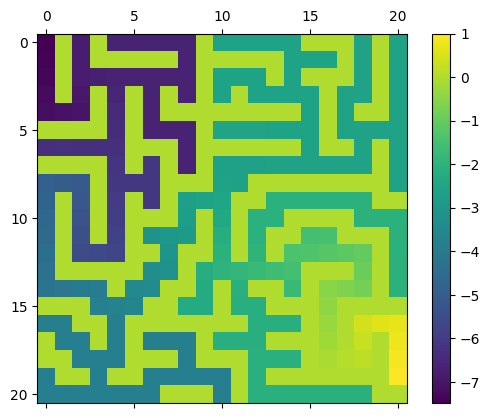

In [ ]:
print("World 4 SARSA")
p, Q, _, _, paths, path_length = policy(
    w4, alpha=0.1, epsilon=0.05, n_episodes=1000,algorithm = SARSA
)
plot_qmap(Q)

World 4 Q-Learning
Converge en 722 episodios. Tamaño: 82


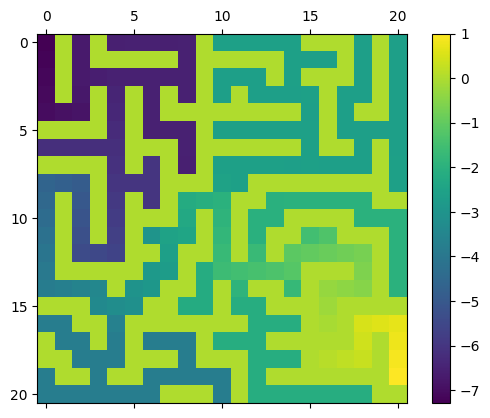

In [ ]:
print("World 4 Q-Learning")
p, Q, _, _, paths, path_length = policy(
    w4, alpha=0.1, epsilon=0.05, n_episodes=1000, algorithm = Q_learning
)
plot_qmap(Q)


Como vemos, son bastante similares. Se observa un valor de 0 en los obstáculos, y después vemos cómo el valor va aumentando conforme nos acercamos a la meta. Podemos ver otro ejemplo de otro mapa:

World 3 SARSA
Converge en 1464 episodios. Tamaño: 40


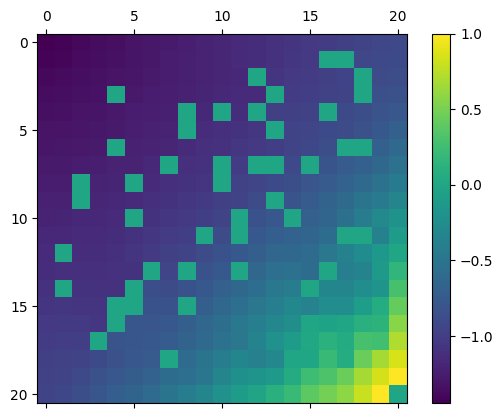

In [ ]:
print("World 3 SARSA")
p, Q, _, _, paths, path_length = policy(
    w3g, alpha=0.1, epsilon=0.05, gamma=0.95, n_episodes=5000,
    algorithm = SARSA
)
plot_qmap(Q)

World 3 Q-learning
Converge en 1359 episodios. Tamaño: 40


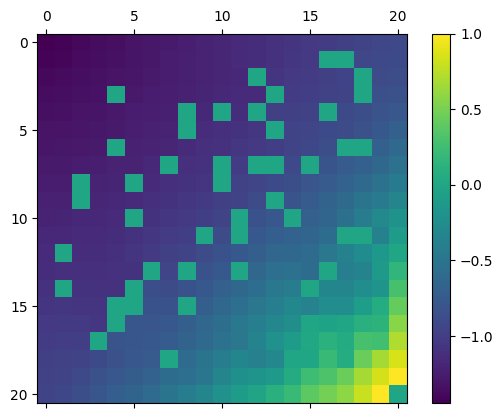

In [ ]:
print("World 3 Q-learning")
p2, Q2, _, _, paths2, path_length = policy(
    w3g, alpha=0.1, epsilon=0.05, gamma=0.95, n_episodes=5000,
    algorithm = Q_learning
)
plot_qmap(Q)

Pasamos ahora a inspeccionar cuál de los dos métodos genera más valor. Dibujamos una gráfica con la evolución temporal (siguiendo la política final) de la función de valor Q.

In [ ]:
def plot_Q_ev(policy, world, Q, agent, actions, label=None):
    state = agent.state
    vec = []

    # Si no llega al objetivo en HxW pasos, está ciclando
    for step in range(world.size[0] * world.size[1]):
        if world.objetivo(state):
            break

        indice_accion = policy[state[0], state[1]]
        accion = actions[indice_accion]
        state, R = agent.checkAction(state, accion)
        vec.append(np.max(Q[state[0], state[1], :]))

    plt.plot(vec, label=label)

In [ ]:
p, Q, _, _, paths1, path_length1 = policy(
    w3g, alpha=0.1, epsilon=0.2, n_episodes=2000,
    algorithm=SARSA, verbose1=False, verbose2=False, max_steps=1000
)

p2, Q2, _, _, paths2, path_length2 = policy(
    w3g, alpha=0.1, epsilon=0.2, n_episodes=2000,
    algorithm=Q_learning, verbose1=False, verbose2=False, max_steps=1000
)

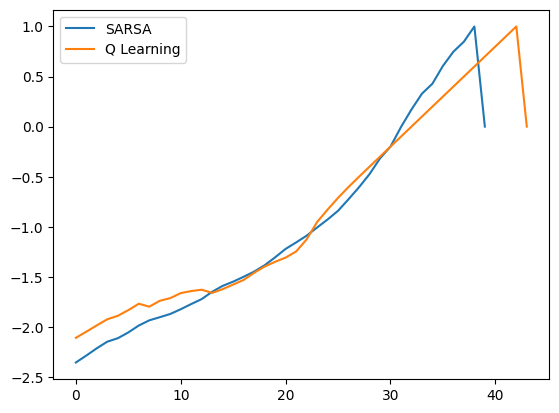

In [ ]:
# Llamadas a la función plot_Q_ev
plot_Q_ev(p, w3g, Q, Agent(w3g, estado_inicial), actions, label="SARSA")
plot_Q_ev(p2, w3g, Q2, Agent(w3g, estado_inicial), actions, label="Q Learning")
plt.legend()
plt.show()

**Como vemos tanto en el anterior como en pruebas posteriores...**

Vemos que, tal y como se observo en el enlace que se mencionaba en el enunciado, el método de Q-learning genera más valor a lo largo de los pasos en el laberinto. Además, podemos tomar el punto en el que comienza a descender el valor como el punto de convergencia, pues significa que se ha acabado la meta. En este caso se observa que tardan ambos más o menos lo mismo. Podemos hacer otra prueba, donde vemos que sigue siendo mayor el valor de Q-learning que SARSA, el cual es con el mundo 1 grande, pero si probamos con el mundo 2, el mapa grande en una mayor parte del tiempo va a ser mejor que SARSA que Q-learning, pero si nos fijamos la diferencia es menor que cuando Q-learning tiene un mayor valor, por lo que tiende a tener mejores valores.

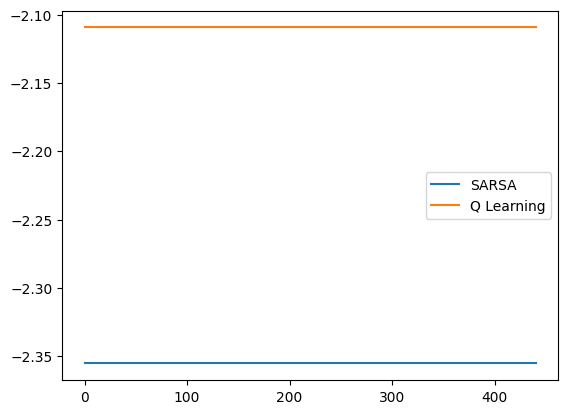

In [ ]:
plot_Q_ev(p, w1g, Q, Agent(w1g, estado_inicial), actions, label="SARSA")
plot_Q_ev(p2, w1g, Q2, Agent(w1g, estado_inicial), actions, label="Q Learning")
plt.legend()
plt.show()

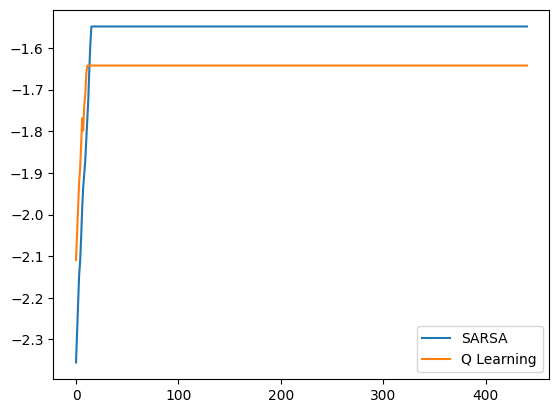

In [ ]:
plot_Q_ev(p, w2g, Q, Agent(w2g, estado_inicial), actions, label="SARSA")
plot_Q_ev(p2, w2g, Q2, Agent(w2g, estado_inicial), actions, label="Q Learning")
plt.legend()
plt.show()

**Nota: Las siguientes variables pueden ser interesantes para valorar los resultados: Diferencia entre la política resultante y la política óptima, número de iteraciones necesarias para converger, retorno total del problema y retorno obtenido en cada episodio.**

3.   **Comentad las diferencias cuando se aplica una mayor exploración ($\epsilon$ más alto) y una mayor explotación ($\epsilon$ más bajo). ¿Cuál converge más rápido? ¿Cuál obtiene más valor? ¿Qué estrategia piensas que podría usarse para explorar y explotar de forma más inteligente?**



Considereaciones:
- El número de episodios máxima a ejecutar será de 1800 para reducir el coste computacional, ya que con los mapas grandes o complejos que no convergen o tardan en ello, el tiempo de ejecución es muy alto.
- Para comparar los valores devueltos se ha decidido escoger el valor máximo en cada estado y comparando el valor medio en cada uno de los epsilon. Con esto obtenemos una medida del rendimiento promedio del agente a lo largo del entrenamiento con diferentes tasas de exploración.

In [ ]:
def encontrar_epsilon_optimo(mundos, epsilons, algorithm,verbose=False):
    mejores_epsilon_convergencia = {}
    mejores_epsilon_valor = {}

    for nombre, mundo in mundos:
        epsilon_optimo_conv = None
        politica_optima_conv = None
        episodios_optimos_conv = np.inf

        epsilon_optimo_valor = None
        politica_optima_valor = None
        Q_mayor = None
        max_medio_Q_valor_mayor = np.NINF

        for epsilon in epsilons:
            politica, Q, episodios, converge, _, _ = policy(
                mundo, alpha=0.2, epsilon=epsilon, n_episodes=1800, algorithm = algorithm, verbose2=False)

            if episodios < episodios_optimos_conv and episodios > 0:
                epsilon_optimo_conv = epsilon
                politica_optima_conv = politica
                episodios_optimos_conv = episodios

            max_Q_estado = np.max(Q, axis=2)
            max_Q_medio_valor = np.mean(max_Q_estado)

            if max_Q_medio_valor > max_medio_Q_valor_mayor:
                max_medio_Q_valor_mayor = max_Q_medio_valor
                epsilon_optimo_max_q = epsilon
                politica_optima_max_q = politica
                Q_mayor = max_Q_estado

        mejores_epsilon_convergencia[nombre] = (epsilon_optimo_conv, episodios_optimos_conv, politica_optima_conv)
        mejores_epsilon_valor[nombre] = (epsilon_optimo_max_q, politica_optima_max_q,Q_mayor)

        if verbose:
          print("-" * 50)
          print(f"Mejor epsilon para rapidez en converger para {nombre}: {epsilon_optimo_conv}")
          print(f"Mejor epsilon para mayor valor para {nombre}: {epsilon_optimo_max_q}")

    return mejores_epsilon_convergencia,mejores_epsilon_valor

In [ ]:
mundos = [("w1p", w1p), ("w1m", w1m), ("w1g",w1g),("w2p", w2p), ("w2m", w2m), ("w2g",w2g),("w3p", w3p), ("w3m", w3m), ("w3g",w3g),("w4",w4)]
epsilons=[0, 0.01, 0.1, 0.2, 0.5, 1]
resultados_convergencia_SARSA, resultados_valor_SARSA = encontrar_epsilon_optimo(mundos,epsilons,SARSA)

In [ ]:
data_convergencia = [(nombre, resultado[0], resultado[1]) for nombre, resultado in resultados_convergencia_SARSA.items()]
df_convergencia_eps_SARSA = pd.DataFrame(data_convergencia, columns=["Mundo", "Epsilon Óptimo (Convergencia)", "Episodios Óptimos (Convergencia)"])


data_valor = [(nombre, resultado[0], np.mean(resultado[2])) for nombre, resultado in resultados_valor_SARSA.items()]
df_valor_eps_SARSA = pd.DataFrame(data_valor, columns=["Mundo", "Epsilon Óptimo (Valor Máximo de Q)", "Valor Máximo de Q"])

In [ ]:
df_convergencia_eps_SARSA

,Mundo,Epsilon Óptimo (Convergencia),Episodios Óptimos (Convergencia)
0,w1p,1.00,15
1,w1m,1.00,105
2,w1g,0.00,1307
3,w2p,0.10,5
4,w2m,0.01,10
5,w2g,0.01,85
6,w3p,0.10,13
7,w3m,0.01,64
8,w3g,1.00,152
9,w4,0.01,406


In [ ]:
df_valor_eps_SARSA

,Mundo,Epsilon Óptimo (Valor Máximo de Q),Valor Máximo de Q
0,w1p,0,-0.075185
1,w1m,0,-0.909302
2,w1g,0,-5.997867
3,w2p,0,0.029243
4,w2m,0,-0.025195
5,w2g,0,-0.300033
6,w3p,0,0.032902
7,w3m,0,-0.153491
8,w3g,0,-0.835053
9,w4,0,-1.776799


SARSA:

En cuanto a la convergencia, el valor de epsilon óptimo para converger rápidamente varía según el tamaño y la complejidad del laberinto. Por ejemplo, para los mundos más pequeños (w1p, w1m, w2p, w3p), un valor de epsilon alto, o al menos mayores que para mundos grandes (1 y 0.1) parece ser más efectivo para converger rápidamente. Esto puede deberse a que en laberintos más simples, es útil explorar agresivamente para encontrar el camino óptimo rápidamente.

Para mundos de tamaño medio y grande (w1g, w2m, w2g, w3m, w4), valores más bajos de epsilon (0, 0.01) parecen ser más efectivos para converger rápidamente. Esto puede deberse a que en laberintos más grandes y complejos, la exploración agresiva inicial puede llevar a una exploración excesiva y a un aumento en el tiempo necesario para converger. (Aunque en esta ejecución hay una excepción, el cual es w3g con epsilon 1. Lo cual es poco habitual, ya que en pruebas anteriores del mismo codigo tiende a dar resultados más acordes con los dichos como sería otra ejecución con epsilon 1 para los mundos pequeños w1p, w1m y w2p, y valores bajos de epsilon (0.01 y 0.1) para w1g, w2m, w2g, w3m, w3g y w4, siendo estos considerados mundos de tamaño alto. Estos cambios puede deberse a generar de nuevo los mundos y los mundos 2 y 3 tenian obstaculos aleatorios).

Sin embargo, es importante tener en cuenta que la elección del valor de epsilon también puede depender de otros factores, como la disposición de los obstáculos y la presencia de teletransporte útil o inútil en el laberinto.

En general, no hay un valor único de epsilon que funcione mejor para todos los mundos. Es importante ajustar este parámetro según las características específicas de cada laberinto y realizar experimentos para determinar el valor óptimo de epsilon para cada caso.

En cuanto al valor se observa que el valor máximo se obtiene siempre cuando se le da prioridad a la explotación. Es decir, siempre se elige la mejor acción posible en cada estado basada en los valores actuales de Q. Como resultado, el agente explota completamente el conocimiento que ha adquirido hasta el momento y no realiza ninguna exploración aleatoria. Esto significa que, durante el entrenamiento, el agente sigue la política óptima que ha aprendido hasta el momento, lo que resulta en la maximización de los valores de Q en cada estado.








In [ ]:
resultados_convergencia_QLearn, resultados_valor_QLearn = encontrar_epsilon_optimo(mundos,epsilons,Q_learning)

In [ ]:
data_convergencia = [(nombre, resultado[0], resultado[1]) for nombre, resultado in resultados_convergencia_QLearn.items()]
df_convergencia_eps_QLearn = pd.DataFrame(data_convergencia, columns=["Mundo", "Epsilon Óptimo (Convergencia)", "Episodios Óptimos (Convergencia)"])


data_valor = [(nombre, resultado[0], np.mean(resultado[2])) for nombre, resultado in resultados_valor_QLearn.items()]
df_valor_eps_QLearn = pd.DataFrame(data_valor, columns=["Mundo", "Epsilon Óptimo (Valor Máximo de Q)", "Valor Máximo de Q"])

In [ ]:
df_convergencia_eps_QLearn

,Mundo,Epsilon Óptimo (Convergencia),Episodios Óptimos (Convergencia)
0,w1p,1.00,10
1,w1m,1.00,89
2,w1g,0.50,1150
3,w2p,0.50,5
4,w2m,0.01,10
5,w2g,0.10,81
6,w3p,1.00,10
7,w3m,1.00,17
8,w3g,0.50,486
9,w4,0.50,346


In [ ]:
df_valor_eps_QLearn

,Mundo,Epsilon Óptimo (Valor Máximo de Q),Valor Máximo de Q
0,w1p,0.5,-0.067824
1,w1m,0.0,-0.909302
2,w1g,1.0,-0.498642
3,w2p,1.0,0.044392
4,w2m,0.5,-0.020762
5,w2g,0.1,-0.260424
6,w3p,0.5,0.084973
7,w3m,0.5,-0.127542
8,w3g,1.0,-0.799258
9,w4,1.0,-0.629002


QLearn:

En cuanto a la convergencia se observa una gran diferencia respecto al uso del algoritma SARSA. En la mayoría de casos tiende a valores mas altos dando mucha mayor prioridad a la exploración en frente a la explotación.

En SARSA, el agente elige su próxima acción basada en una política de comportamiento (ε-greedy), donde selecciona aleatoriamente una acción con una probabilidad epsilon y elige la acción óptima con una probabilidad 1 - epsilon. Por lo tanto, un valor de epsilon más bajo puede ser suficiente para garantizar una exploración adecuada mientras que aún se explotan las acciones con mayor valor de Q.

En contraste, en Q-learning, el agente siempre elige la acción con el valor de Q más alto, sin explorar aleatoriamente. Por lo tanto, un valor de epsilon más alto puede ser necesario para garantizar una exploración suficiente del espacio de acciones y estados, especialmente en entornos complejos donde la convergencia puede llevar más tiempo.

En cuanto al valor, también se observan valores muy altos de epsilon. Esto es debido a que una mayor exploración facilitada por valores mayores de epsilon puede llevar a una mejor identificación de políticas óptimas más rápidamente en algunos casos. Aunque esto puede resultar en una mayor variabilidad en el rendimiento durante el entrenamiento, puede conducir a mejores resultados a largo plazo al permitir que el agente explore y aprenda más sobre el entorno. Todo esto combinado con su política de comportamiento hace que se obtengan mejores valores, una razón igual que al caso de la convergencia.

En cuanto a una estrategía óptima para el uso de exploración o explotación, es ajustando de manera dinámica el valor de la tasa de exploración (epsilon) durante el entrenamiento. Una técnica conocida es el uso del parametro de decay (no usado en este trabajo).

Esta técnica onsiste en reducir gradualmente el valor de epsilon a medida que avanza el entrenamiento. Esto se hace multiplicando epsilon por un factor de decaimiento después de cada episodio o después de un número determinado de pasos.

El propósito principal del decaimiento es permitir una mayor exploración al principio del entrenamiento, cuando el agente aún está aprendiendo sobre el entorno y necesita explorar más para descubrir las mejores acciones. A medida que el entrenamiento avanza y el agente adquiere más conocimiento sobre el entorno, se reduce gradualmente la exploración y se da más peso a la explotación de las acciones óptimas aprendidas.

4.   **Comentad las diferencias cuando se varían otros parámetros como el número de episodios, el ratio de aprendizaje ($\alpha$) o el factor de descuento ($\gamma$). ¿Qué valores dan mejores resultados?**

### Factor de aprendizaje

Consideraciones:
- Cuando el valor del factor de aprendizaje es demasiado alto dificulta la convergencia del algoritmo de aprendizaje, especialmente en entornos complejos. Si el factor de aprendizaje es demasiado alto, las actualizaciones pueden volverse demasiado agresivas, lo que lleva a oscilaciones o incluso a la divergencia de los valores de Q. Por lo que los valores elegidos para probar son [0.1, 0.2, 0.3, 0.4, 0.5].
- Para su ejecución se utilizan los epsilón óptimos de cada mundo calculados en el anterior apartado y así comparar la mejora producida con un factor de aprendizaje óptimo.

In [ ]:
def encontrar_alpha_optimo(mundos, epsilons, alphas, algorithm, conv, verbose=False):
    mejores_alpha = {}
    for (nombre, mundo), epsilon in zip(mundos,epsilons):
        alpha_optimo= None
        Q_mayor=None
        politica_optima = None
        if conv:
          episodios_optimos = np.inf
        else: max_medio_Q_valor_mayor = np.NINF

        for alpha in alphas:
            politica, Q, episodios, converge, _, _ = policy(
                mundo, alpha=alpha, epsilon=epsilon, n_episodes=1800, algorithm=algorithm, verbose2=False)

            if conv:
              if episodios < episodios_optimos and episodios > 0:
                  alpha_optimo = alpha
                  politica_optima = politica
                  episodios_optimos = episodios
            else:
              max_Q_estado = np.max(Q, axis=2)
              max_Q_medio_valor = np.mean(max_Q_estado)

              if max_Q_medio_valor > max_medio_Q_valor_mayor:
                  max_medio_Q_valor_mayor = max_Q_medio_valor
                  alpha_optimo = alpha
                  politica_optima = politica
                  Q_mayor = max_Q_estado

        if conv:
          mejores_alpha[nombre] = (alpha_optimo, episodios_optimos, politica_optima)
        else: mejores_alpha[nombre] = (alpha_optimo, politica_optima, Q_mayor)

        if verbose:
            print("-" * 50)
            if conv:
              print(f"Mejor alpha para rapidez en converger para {nombre}: {alpha_optimo}")
            else: print(f"Mejor alpha para mayor valor para {nombre}: {alpha_optimo}")

    return mejores_alpha



In [ ]:
mundos = [("w1p", w1p), ("w1m", w1m), ("w1g",w1g),("w2p", w2p), ("w2m", w2m), ("w2g",w2g),("w3p", w3p), ("w3m", w3m), ("w3g",w3g),("w4",w4)]
alphas = [0.1, 0.2, 0.3, 0.4, 0.5]

SARSA:

In [ ]:
mejores_alpha_convergencia_SARSA= encontrar_alpha_optimo(mundos, df_convergencia_eps_SARSA["Epsilon Óptimo (Convergencia)"].values, alphas, SARSA, True, verbose=False)
mejores_alpha_valor_SARSA= encontrar_alpha_optimo(mundos, df_valor_eps_SARSA["Epsilon Óptimo (Valor Máximo de Q)"].values, alphas, SARSA, False, verbose=False)

In [ ]:
data_convergencia = [(nombre, resultado[0], resultado[1]) for nombre, resultado in mejores_alpha_convergencia_SARSA.items()]
df_alpha_convergencia_SARSA = pd.DataFrame(data_convergencia, columns=["Mundo", "Alpha Óptimo (Convergencia)", "Episodios Óptimos (Convergencia)"])


data_valor = [(nombre, resultado[0], np.mean(resultado[2])) for nombre, resultado in mejores_alpha_valor_SARSA.items()]
df_alpha_valor_SARSA = pd.DataFrame(data_valor, columns=["Mundo", "Alpha Óptimo (Valor Máximo de Q)", "Valor Máximo de Q"])

In [ ]:
df_alpha_convergencia_SARSA

,Mundo,Alpha Óptimo (Convergencia),Episodios Óptimos (Convergencia)
0,w1p,0.3,13
1,w1m,0.3,102
2,w1g,0.5,553
3,w2p,0.2,5
4,w2m,0.2,10
5,w2g,0.5,52
6,w3p,0.5,5
7,w3m,0.4,55
8,w3g,0.2,152
9,w4,0.5,180


In [ ]:
df_alpha_valor_SARSA

,Mundo,Alpha Óptimo (Valor Máximo de Q),Valor Máximo de Q
0,w1p,0.5,0.009406
1,w1m,0.4,-0.887856
2,w1g,0.1,-5.810212
3,w2p,0.5,0.087219
4,w2m,0.2,-0.025195
5,w2g,0.1,-0.265708
6,w3p,0.5,0.076375
7,w3m,0.1,-0.144184
8,w3g,0.1,-0.810593
9,w4,0.1,-1.775474


Según el caso, el factor de aprendizaje óptimo varía entre valores. En cuanto a la convergencia no se consigue observar nada en especial. Pero en cuanto al valor máximo medio se observa que los mapas más sencillos (w1p, w1m, w2p y w3p) obtienen un valor más óptimo con factores de aprendizaje mayores y el resto de casos con valores más bajos.

In [ ]:
df_convergencia_eps_SARSA["Episodios Óptimos (Convergencia)"].values - df_alpha_convergencia_SARSA["Episodios Óptimos (Convergencia)"]

0      2
1      3
2    754
3      0
4      0
5     33
6      8
7      9
8      0
9    226
Name: Episodios Óptimos (Convergencia), dtype: int64

In [ ]:
df_alpha_valor_SARSA["Valor Máximo de Q"] - df_valor_eps_SARSA["Valor Máximo de Q"].values

0    0.084591
1    0.021446
2    0.187655
3    0.057976
4    0.000000
5    0.034325
6    0.043473
7    0.009306
8    0.024460
9    0.001325
Name: Valor Máximo de Q, dtype: float64

En cuanto a la mejora con el añadido de un factor de aprendizaje óptimo según el caso es nulo, pequeña o grande, pero nunca produce un empeoramiento. Esto ocurre tanto para convergencia como para valor.

QLearn:

In [ ]:
mejores_alpha_convergencia_Qlearn= encontrar_alpha_optimo(mundos, df_convergencia_eps_QLearn["Epsilon Óptimo (Convergencia)"].values, alphas, Q_learning, True, verbose=False)
mejores_alpha_valor_Qlearn= encontrar_alpha_optimo(mundos, df_valor_eps_QLearn["Epsilon Óptimo (Valor Máximo de Q)"].values, alphas, Q_learning, False, verbose=False)

In [ ]:
data_convergencia = [(nombre, resultado[0], resultado[1]) for nombre, resultado in mejores_alpha_convergencia_Qlearn.items()]
df_alpha_convergencia_Qlearn = pd.DataFrame(data_convergencia, columns=["Mundo", "Alpha Óptimo (Convergencia)", "Episodios Óptimos (Convergencia)"])


data_valor = [(nombre, resultado[0], np.mean(resultado[2])) for nombre, resultado in mejores_alpha_valor_Qlearn.items()]
df_alpha_valor_Qlearn = pd.DataFrame(data_valor, columns=["Mundo", "Alpha Óptimo (Valor Máximo de Q)", "Valor Máximo de Q"])

In [ ]:
df_alpha_convergencia_Qlearn

,Mundo,Alpha Óptimo (Convergencia),Episodios Óptimos (Convergencia)
0,w1p,0.5,7
1,w1m,0.4,61
2,w1g,0.5,534
3,w2p,0.2,5
4,w2m,0.2,10
5,w2g,0.4,43
6,w3p,0.5,4
7,w3m,0.4,16
8,w3g,0.5,230
9,w4,0.5,169


In [ ]:
df_alpha_valor_Qlearn

,Mundo,Alpha Óptimo (Valor Máximo de Q),Valor Máximo de Q
0,w1p,0.4,-0.003308
1,w1m,0.4,-0.887856
2,w1g,0.1,-0.437425
3,w2p,0.4,0.077988
4,w2m,0.3,-0.008975
5,w2g,0.1,-0.239913
6,w3p,0.5,0.118984
7,w3m,0.3,-0.108459
8,w3g,0.4,-0.790192
9,w4,0.1,-0.552869


Estos son los valores óptimos para los diferentes mundo usando el algoritmo Qlearn. No se observa un patrón claro, por lo que cada uno se irá adaptando a cada uno de los casos.

In [ ]:
df_convergencia_eps_QLearn["Episodios Óptimos (Convergencia)"].values - df_alpha_convergencia_Qlearn["Episodios Óptimos (Convergencia)"]

0      3
1     28
2    616
3      0
4      0
5     38
6      6
7      1
8    256
9    177
Name: Episodios Óptimos (Convergencia), dtype: int64

In [ ]:
df_alpha_valor_Qlearn["Valor Máximo de Q"] - df_valor_eps_QLearn["Valor Máximo de Q"].values

0    0.064516
1    0.021446
2    0.061217
3    0.033596
4    0.011787
5    0.020511
6    0.034011
7    0.019083
8    0.009066
9    0.076134
Name: Valor Máximo de Q, dtype: float64

En cuanto a la diferencia de mejora con valor óptimo del factor de aprendizaje se observa, como en el caso del algoritmo SARSA, que se produce o una mejora nula, pequeña o significativa, pero nunca empeorando la mejora conseguida con un epsilón óptimo.

### Factor de descuento

- Para su ejecución se utilizan los epsilón óptimos de cada mundo calculados en el anterior apartado.
- También para su ejecución se utilizan los alphas óptimos de cada mundo calculados en el anterior apartado y así comparar la mejora producida con un factor de descuento óptimo.
- Se ha decidido probar estos valores [0.3, 0.4, 0.5, 0.7, 0.9, 1] para buscar el valor óptimo del factor de descuento. En algunos de los mundos con valores pequeño no llegan a converger por lo que el coste computacional de ejecutar esta función puede ser muy elevado.

In [ ]:
def encontrar_gamma_optimo(mundos, epsilons, alphas, gammas, algorithm, conv, verbose=False):
    mejores_alpha = {}
    for (nombre, mundo), epsilon, alpha in zip(mundos,epsilons,alphas):
        gamma_optimo= None
        Q_mayor=None
        politica_optima = None
        if conv:
          episodios_optimos = np.inf
        else: max_medio_Q_valor_mayor = np.NINF

        for gamma in gammas:
            politica, Q, episodios, converge, _, _ = policy(
                mundo, alpha=alpha, epsilon=epsilon, gamma=gamma, n_episodes=1800, algorithm=algorithm, verbose2=False)

            if conv:
              if episodios < episodios_optimos and episodios > 0:
                  gamma_optimo = gamma
                  politica_optima = politica
                  episodios_optimos = episodios
            else:
              max_Q_estado = np.max(Q, axis=2)
              max_Q_medio_valor = np.mean(max_Q_estado)

              if max_Q_medio_valor > max_medio_Q_valor_mayor:
                  max_medio_Q_valor_mayor = max_Q_medio_valor
                  gamma_optimo = gamma
                  politica_optima = politica
                  Q_mayor = max_Q_estado

        if conv:
          mejores_alpha[nombre] = (gamma_optimo, episodios_optimos, politica_optima)
        else: mejores_alpha[nombre] = (gamma_optimo, politica_optima, Q_mayor)

        if verbose:
            print("-" * 50)
            if conv:
              print(f"Mejor gamma para rapidez en converger para {nombre}: {gamma_optimo}")
            else: print(f"Mejor gamma para mayor valor para {nombre}: {gamma_optimo}")

    return mejores_alpha

SARSA:

In [ ]:
gammas = [0.3, 0.4, 0.5, 0.7, 0.9, 1]
mejores_gamma_convergencia_SARSA= encontrar_gamma_optimo(mundos, df_convergencia_eps_SARSA["Epsilon Óptimo (Convergencia)"].values, df_alpha_convergencia_SARSA["Alpha Óptimo (Convergencia)"].values, gammas, SARSA, True, verbose=False)
mejores_gamma_valor_SARSA= encontrar_gamma_optimo(mundos, df_valor_eps_SARSA["Epsilon Óptimo (Valor Máximo de Q)"].values, df_alpha_valor_SARSA["Alpha Óptimo (Valor Máximo de Q)"].values, gammas, SARSA, False, verbose=False)

In [ ]:
data_convergencia = [(nombre, resultado[0], resultado[1]) for nombre, resultado in mejores_gamma_convergencia_SARSA.items()]
df_gamma_convergencia_SARSA = pd.DataFrame(data_convergencia, columns=["Mundo", "Gamma Óptimo (Convergencia)", "Episodios Óptimos (Convergencia)"])


data_valor = [(nombre, resultado[0], np.mean(resultado[2])) for nombre, resultado in mejores_gamma_valor_SARSA.items()]
df_gamma_valor_SARSA = pd.DataFrame(data_valor, columns=["Mundo", "Gamma Óptimo (Valor Máximo de Q)", "Valor Máximo de Q"])

In [ ]:
df_gamma_convergencia_SARSA

,Mundo,Gamma Óptimo (Convergencia),Episodios Óptimos (Convergencia)
0,w1p,0.4,12
1,w1m,0.9,99
2,w1g,1.0,553
3,w2p,0.9,5
4,w2m,0.3,6
5,w2g,0.9,37
6,w3p,1.0,5
7,w3m,0.3,37
8,w3g,0.9,141
9,w4,0.9,177


In [ ]:
df_gamma_valor_SARSA

,Mundo,Gamma Óptimo (Valor Máximo de Q),Valor Máximo de Q
0,w1p,1.0,0.009406
1,w1m,0.3,-0.064500
2,w1g,0.3,-0.041227
3,w2p,0.9,0.087480
4,w2m,0.3,-0.021933
5,w2g,0.3,-0.117775
6,w3p,0.9,0.080357
7,w3m,0.3,-0.088461
8,w3g,0.3,-0.117254
9,w4,0.3,-0.073547


SARSA:

En terminos de convergencia, tiende a ser mejor valores grandes de gamma con valores 0.9 y 1, cumpliendose esto siempre para mundos de mayor dimensión, y de forma mayoritaria para mapas medianos y pequeños a pesar de que haya dos de los 3 medianos con un gamma optimo igual a 0.3 y uno pequeño igual a 0.4.

Un valor más alto de gamma indica que el agente presta más atención a las recompensas futuras, mientras que un valor más bajo de gamma hace que el agente se centre más en las recompensas inmediatas.

Cuando se trata de mundos de mayor dimensión, especialmente aquellos con un mayor número de estados y acciones posibles, un valor más alto de gamma (como 0.9 o 1) puede ser beneficioso para la convergencia. Esto se debe a que en entornos más grandes, las recompensas futuras pueden tener un impacto significativo en el rendimiento general del agente. Con un gamma alto, el agente tiende a priorizar las recompensas a largo plazo y a planificar su comportamiento en consecuencia, lo que puede conducir a una mejor convergencia a una política óptima.

Sin embargo, para mapas más pequeños o medianos, donde las recompensas futuras pueden estar más cerca en el tiempo o ser más predecibles, un valor de gamma más bajo podría ser suficiente para alcanzar la convergencia.

Los valores óptimos de gamma pueden variar según las características específicas del entorno. Por lo que es posible que un mapa pequeño o mediano necesite de un gamma más alto como es nuestro caso.

En cuanto al valor se observa que el factor de descuento que maximiza el valor devuelto en mapas grandes es el mínimo posible en el experimento (0.3) y en los mundos pequeños un valor alto (0.9 y 1).

En entornos grandes, donde hay muchas acciones posibles y las recompensas futuras pueden tener un impacto significativo en el rendimiento general, un valor bajo de gamma (como 0.3) puede ser óptimo. Esto se debe a que un gamma bajo le da más peso a las recompensas inmediatas y menos peso a las recompensas futuras. En entornos complejos y de gran tamaño, es posible que las recompensas futuras sean más inciertas o estén más alejadas en el tiempo, por lo que el agente puede encontrar más beneficioso centrarse en obtener recompensas inmediatas y adaptar su comportamiento en consecuencia.

Por otro lado, en entornos pequeños donde las recompensas futuras son más predecibles y están más cerca en el tiempo, un valor más alto de gamma (como 0.9 o 1) puede ser más beneficioso. En estos entornos, el agente puede planificar y tomar decisiones considerando más las recompensas futuras, lo que puede resultar en una política más óptima y un rendimiento general mejorado

In [ ]:
df_alpha_convergencia_SARSA["Episodios Óptimos (Convergencia)"].values - df_gamma_convergencia_SARSA["Episodios Óptimos (Convergencia)"]

0     1
1     3
2     0
3     0
4     4
5    15
6     0
7    18
8    11
9     3
Name: Episodios Óptimos (Convergencia), dtype: int64

In [ ]:
df_gamma_valor_SARSA["Valor Máximo de Q"] - df_alpha_valor_SARSA["Valor Máximo de Q"].values

0    0.000000
1    0.823356
2    5.768985
3    0.000261
4    0.003263
5    0.147933
6    0.003982
7    0.055723
8    0.693338
9    1.701927
Name: Valor Máximo de Q, dtype: float64

Se observa que al optimizar el factor de descuento se producen en la mayoria de los mundos una mejora tanto en la convergencia como en maximizar el valor devuelto. Con este último calculo para la optimización del factor de descuento, ya se han seleccionado los valores para los parametros más óptimos que maximizan los aspectos estudiados para el algoritmo SARSA, los cuales se observaran en la tablas siguiente:

Convergencia:

In [ ]:
parametros_optimizados_conv_SARSA = pd.DataFrame({
    "Mundo": ["w1p", "w1m", "w1g", "w2p", "w2m", "w2g", "w3p", "w3m", "w3g", "w4"],
    "Epsilon Óptimo (Convergencia)": df_convergencia_eps_SARSA["Epsilon Óptimo (Convergencia)"].values,
    "Alpha Óptimo (Convergencia)": df_alpha_convergencia_SARSA["Alpha Óptimo (Convergencia)"].values,
    "Gamma Óptimo (Convergencia)": df_gamma_convergencia_SARSA["Gamma Óptimo (Convergencia)"].values,
    "Episodios Óptimos (Convergencia)": df_gamma_convergencia_SARSA["Episodios Óptimos (Convergencia)"].values
})
parametros_optimizados_conv_SARSA

,Mundo,Epsilon Óptimo (Convergencia),Alpha Óptimo (Convergencia),Gamma Óptimo (Convergencia),Episodios Óptimos (Convergencia)
0,w1p,1.00,0.3,0.4,12
1,w1m,1.00,0.3,0.9,99
2,w1g,0.00,0.5,1.0,553
3,w2p,0.10,0.2,0.9,5
4,w2m,0.01,0.2,0.3,6
5,w2g,0.01,0.5,0.9,37
6,w3p,0.10,0.5,1.0,5
7,w3m,0.01,0.4,0.3,37
8,w3g,1.00,0.2,0.9,141
9,w4,0.01,0.5,0.9,177


Valor:

In [ ]:
parametros_optimizados_valor_SARSA = pd.DataFrame({
    "Mundo": ["w1p", "w1m", "w1g", "w2p", "w2m", "w2g", "w3p", "w3m", "w3g", "w4"],
    "Epsilon Óptimo (Valor Máximo de Q)": df_valor_eps_SARSA["Epsilon Óptimo (Valor Máximo de Q)"].values,
    "Alpha Óptimo (Valor Máximo de Q)": df_alpha_valor_SARSA["Alpha Óptimo (Valor Máximo de Q)"].values,
    "Gamma Óptimo (Valor Máximo de Q)": df_gamma_valor_SARSA["Gamma Óptimo (Valor Máximo de Q)"].values,
    "Valor Máximo Medio de Q": df_gamma_valor_SARSA["Valor Máximo de Q"].values
})
parametros_optimizados_valor_SARSA

,Mundo,Epsilon Óptimo (Valor Máximo de Q),Alpha Óptimo (Valor Máximo de Q),Gamma Óptimo (Valor Máximo de Q),Valor Máximo Medio de Q
0,w1p,0,0.5,1.0,0.009406
1,w1m,0,0.4,0.3,-0.064500
2,w1g,0,0.1,0.3,-0.041227
3,w2p,0,0.5,0.9,0.087480
4,w2m,0,0.2,0.3,-0.021933
5,w2g,0,0.1,0.3,-0.117775
6,w3p,0,0.5,0.9,0.080357
7,w3m,0,0.1,0.3,-0.088461
8,w3g,0,0.1,0.3,-0.117254
9,w4,0,0.1,0.3,-0.073547


Se ha obtenida tanta mejora comparada con las pruebas simples realizadas que el mundo w1p tarda en converge 42 episodios y optimizandolo tarda 12 episodios o el mundo w1g que tardaba 1307 episodios y ahora 553. Esta mejora tan enorme se observa con todos los mundos y también maximizando el valor de Q.

QLearn:

In [ ]:
mejores_gamma_convergencia_Qlearn= encontrar_gamma_optimo(mundos, df_convergencia_eps_QLearn["Epsilon Óptimo (Convergencia)"].values,df_alpha_convergencia_Qlearn["Alpha Óptimo (Convergencia)"].values, gammas, Q_learning, True, verbose=False)
mejores_gamma_valor_Qlearn= encontrar_gamma_optimo(mundos, df_valor_eps_QLearn["Epsilon Óptimo (Valor Máximo de Q)"].values, df_alpha_valor_Qlearn["Alpha Óptimo (Valor Máximo de Q)"].values, gammas, Q_learning, False, verbose=False)

In [ ]:
data_convergencia = [(nombre, resultado[0], resultado[1]) for nombre, resultado in mejores_gamma_convergencia_Qlearn.items()]
df_gamma_convergencia_Qlearn = pd.DataFrame(data_convergencia, columns=["Mundo", "Gamma Óptimo (Convergencia)", "Episodios Óptimos (Convergencia)"])


data_valor = [(nombre, resultado[0], np.mean(resultado[2])) for nombre, resultado in mejores_gamma_valor_Qlearn.items()]
df_gamma_valor_Qlearn = pd.DataFrame(data_valor, columns=["Mundo", "Gamma Óptimo (Valor Máximo de Q)", "Valor Máximo de Q"])

In [ ]:
df_gamma_convergencia_Qlearn

,Mundo,Gamma Óptimo (Convergencia),Episodios Óptimos (Convergencia)
0,w1p,1.0,7
1,w1m,0.9,61
2,w1g,1.0,534
3,w2p,0.5,4
4,w2m,1.0,10
5,w2g,1.0,43
6,w3p,0.9,4
7,w3m,0.7,16
8,w3g,1.0,230
9,w4,1.0,169


In [ ]:
df_gamma_valor_Qlearn

,Mundo,Gamma Óptimo (Valor Máximo de Q),Valor Máximo de Q
0,w1p,1.0,-0.003308
1,w1m,0.3,-0.064500
2,w1g,0.3,-0.022154
3,w2p,1.0,0.077988
4,w2m,1.0,-0.008975
5,w2g,0.3,-0.117854
6,w3p,1.0,0.118984
7,w3m,0.3,-0.087304
8,w3g,0.3,-0.117026
9,w4,0.3,-0.040628


En cuanto a la convergencia, y comparandolo con SARSA parece que todos los mundos se ven beneficiados con valores medios y altos del factor de descuento.

En el caso de Q-learning, una alta tasa de descuento puede ayudar al agente a evitar quedarse atascado en óptimos locales y explorar de manera más efectiva el espacio de estados y acciones, lo que conduce a una convergencia más rápida hacia una política óptima.

En cuanto a maximizar el valor se encuantra algo totalmente diferente comparandolo con SARSA. Todos los mundos pequeños y el mundo w2m tiene valores alto y el resto de mundos mas complejos bajos en torno al factor de descuento.

En entornos pequeños y menos complejos, las relaciones entre las acciones y las recompensas suelen ser más directas y predecibles. Esto significa que el agente puede confiar más en las recompensas futuras y estar más inclinado a valorarlas en comparación con los entornos más complejos, donde las relaciones pueden ser más ambiguas y difíciles de predecir. Y así maximizar el valor de Q, y lo contrario ocurre con los mundos más complejos.

In [ ]:
df_alpha_convergencia_Qlearn["Episodios Óptimos (Convergencia)"].values - df_gamma_convergencia_Qlearn["Episodios Óptimos (Convergencia)"]

0    0
1    0
2    0
3    1
4    0
5    0
6    0
7    0
8    0
9    0
Name: Episodios Óptimos (Convergencia), dtype: int64

In [ ]:
df_gamma_valor_Qlearn["Valor Máximo de Q"] - df_alpha_valor_Qlearn["Valor Máximo de Q"].values

0    0.000000
1    0.823356
2    0.415272
3    0.000000
4    0.000000
5    0.122059
6    0.000000
7    0.021155
8    0.673166
9    0.512240
Name: Valor Máximo de Q, dtype: float64

En cuanto a la convergencia solo sufre un mínima mejora en uno de los mundos, pero en el valor máximo medio si que se producen mejoras en distintos mundos.

Con este último calculo para la optimización del factor de descuento, ya se han seleccionado los mejores valores para los parametros que maximizan los aspectos estudiados para el algoritmo QLearn, los cuales se observaran en la tablas siguiente:

Convergencia:

In [ ]:
parametros_optimizados_conv_Qlearn = pd.DataFrame({
    "Mundo": ["w1p", "w1m", "w1g", "w2p", "w2m", "w2g", "w3p", "w3m", "w3g", "w4"],
    "Epsilon Óptimo (Convergencia)": df_convergencia_eps_QLearn["Epsilon Óptimo (Convergencia)"].values,
    "Alpha Óptimo (Convergencia)": df_alpha_convergencia_Qlearn["Alpha Óptimo (Convergencia)"].values,
    "Gamma Óptimo (Convergencia)": df_gamma_convergencia_Qlearn["Gamma Óptimo (Convergencia)"].values,
    "Episodios Óptimos (Convergencia)": df_gamma_convergencia_Qlearn["Episodios Óptimos (Convergencia)"].values
})
parametros_optimizados_conv_Qlearn

,Mundo,Epsilon Óptimo (Convergencia),Alpha Óptimo (Convergencia),Gamma Óptimo (Convergencia),Episodios Óptimos (Convergencia)
0,w1p,1.00,0.5,1.0,7
1,w1m,1.00,0.4,0.9,61
2,w1g,0.50,0.5,1.0,534
3,w2p,0.50,0.2,0.5,4
4,w2m,0.01,0.2,1.0,10
5,w2g,0.10,0.4,1.0,43
6,w3p,1.00,0.5,0.9,4
7,w3m,1.00,0.4,0.7,16
8,w3g,0.50,0.5,1.0,230
9,w4,0.50,0.5,1.0,169


Valor:

In [ ]:
parametros_optimizados_valor_Qlearn = pd.DataFrame({
    "Mundo": ["w1p", "w1m", "w1g", "w2p", "w2m", "w2g", "w3p", "w3m", "w3g", "w4"],
    "Epsilon Óptimo (Valor Máximo de Q)": df_valor_eps_QLearn["Epsilon Óptimo (Valor Máximo de Q)"].values,
    "Alpha Óptimo (Valor Máximo de Q)": df_alpha_valor_Qlearn["Alpha Óptimo (Valor Máximo de Q)"].values,
    "Gamma Óptimo (Valor Máximo de Q)": df_gamma_valor_Qlearn["Gamma Óptimo (Valor Máximo de Q)"].values,
    "Valor Máximo Medio de Q": df_gamma_valor_Qlearn["Valor Máximo de Q"].values
})
parametros_optimizados_valor_Qlearn

,Mundo,Epsilon Óptimo (Valor Máximo de Q),Alpha Óptimo (Valor Máximo de Q),Gamma Óptimo (Valor Máximo de Q),Valor Máximo Medio de Q
0,w1p,0.5,0.4,1.0,-0.003308
1,w1m,0.0,0.4,0.3,-0.064500
2,w1g,1.0,0.1,0.3,-0.022154
3,w2p,1.0,0.4,1.0,0.077988
4,w2m,0.5,0.3,1.0,-0.008975
5,w2g,0.1,0.1,0.3,-0.117854
6,w3p,0.5,0.5,1.0,0.118984
7,w3m,0.5,0.3,0.3,-0.087304
8,w3g,1.0,0.4,0.3,-0.117026
9,w4,1.0,0.1,0.3,-0.040628


Y ahora se realiza una comparación entre los dos algoritmos, a ver cual de ellos ha llegado a valores mejores en torno a la convergencia y a los valores máximos medios de Q

Convergencia:

In [ ]:
comparacion_conv = pd.DataFrame({
    "Mundo": ["w1p", "w1m", "w1g", "w2p", "w2m", "w2g", "w3p", "w3m", "w3g", "w4"],
    "Episodios Óptimos SARSA": df_gamma_convergencia_SARSA["Episodios Óptimos (Convergencia)"].values,
    "Episodios Óptimos QLearn": df_gamma_convergencia_Qlearn["Episodios Óptimos (Convergencia)"].values
})
comparacion_conv

,Mundo,Episodios Óptimos SARSA,Episodios Óptimos QLearn
0,w1p,12,7
1,w1m,99,61
2,w1g,553,534
3,w2p,5,4
4,w2m,6,10
5,w2g,37,43
6,w3p,5,4
7,w3m,37,16
8,w3g,141,230
9,w4,177,169


In [ ]:
comparacion_valor = pd.DataFrame({
    "Mundo": ["w1p", "w1m", "w1g", "w2p", "w2m", "w2g", "w3p", "w3m", "w3g", "w4"],
    "Valor Máximo Medio de Q SARSA": df_gamma_valor_SARSA["Valor Máximo de Q"].values,
    "Valor Máximo Medio de Q QLearn": df_gamma_valor_Qlearn["Valor Máximo de Q"].values
})
comparacion_valor

,Mundo,Valor Máximo Medio de Q SARSA,Valor Máximo Medio de Q QLearn
0,w1p,0.009406,-0.003308
1,w1m,-0.064500,-0.064500
2,w1g,-0.041227,-0.022154
3,w2p,0.087480,0.077988
4,w2m,-0.021933,-0.008975
5,w2g,-0.117775,-0.117854
6,w3p,0.080357,0.118984
7,w3m,-0.088461,-0.087304
8,w3g,-0.117254,-0.117026
9,w4,-0.073547,-0.040628


Como conclusión podemos decir que Q-learning es mejor que SARSA en terminos generales de convergencia, aunque cuanto mayor es el mundo o mapa, más difuso se vuelve comparar, ya que se empiezan a parecer más la cantidad de episodios empleados que con los mundos de menor dimensión llegando a superar en algunas ocasiones la convergencia en terminos de número de episodios, cosa que no pasa con los mundos de menor tamaño.

Para evaluar cual es mejor en terminos de valores de Q, se tendra en cuenta que un mayor valor de Q en SARSA sugiere que la acción en cuestión tiene un mayor valor de recompensa esperada en comparación con otras acciones en ese estado y bajo la política actual del agente. Y un mayor valor de Q en Q-learning indica que, en promedio, se espera obtener mayores recompensas tomando esa acción en ese estado específico y siguiendo la mejor política posible. Dado que Q-learning no requiere seguir una política específica para aprender, un mayor valor de Q implica que la acción en cuestión es la mejor opción posible en ese estado, independientemente de la política actual del agente. En resumen, en ambos algoritmos, un mayor valor de Q indica que una acción específica en un estado particular tiene un mayor valor de recompensa esperada. En terminos del valor máximo medio de Q, SARSA obtiene mejores resultados en mundos/mapas pequeños que los Q obtenidos con Q-learning, pero segun va aumentando los tamaño de los mundos, Q-learning empieza a acercarse y a obtener mejores resultados que SARSA.


Por lo que, como se ha visto a los largo de la practica, determinar cuál algoritmo es "mejor", SARSA o Q-learning, depende en gran medida del problema específico que se esté abordando y de las condiciones en las que se aplica cada algoritmo. Ambos algoritmos tienen sus propias fortalezas y debilidades, y la elección entre ellos puede depender de varios factores. Aquí hay algunos puntos para considerar al comparar SARSA y Q-learning:

  1. Convergencia: Q-learning converge a la política óptima independientemente de la política inicial del agente, siempre que se cumplan ciertas condiciones, como que se visite cada par estado-acción lo suficiente. SARSA, por otro lado, converge a una política óptima bajo la política ε-greedy utilizada para explorar. Si la exploración es subóptima, SARSA puede converger a una política subóptima.

  2. Exploración vs. Explotación: SARSA es más conservador en términos de exploración porque sigue la política actual del agente para seleccionar acciones. Esto significa que SARSA tiende a explorar de manera más gradual y segura. Q-learning, por otro lado, sigue una política ε-greedy basada en los valores Q actuales, lo que puede llevar a una exploración más agresiva.

  3. Política Final: Q-learning aprende directamente la política óptima en términos de valores Q y luego deriva la política final de estos valores. SARSA aprende la política ε-greedy directamente durante el proceso de aprendizaje. Dependiendo de la aplicación, puede ser preferible tener una estimación de la política final (Q-learning) o aprender directamente la política final (SARSA).

  4. Estabilidad: Q-learning tiende a ser más inestable que SARSA debido a la actualización basada en el valor máximo de Q para el siguiente estado, lo que puede llevar a oscilaciones y divergencia en ciertas condiciones. SARSA, al seguir la política actual del agente, puede ser más estable en términos de convergencia.

En resumen, no hay una respuesta definitiva sobre cuál algoritmo es "mejor". La elección entre SARSA y Q-learning depende de varios factores, incluida la naturaleza del problema, la política de exploración deseada, la estabilidad y la convergencia. A menudo, se recomienda experimentar con ambos algoritmos en el contexto específico de la aplicación para determinar cuál funciona mejor en esa situación particular.